# Multi-Axis Graphical Models Workshop

In this notebook, you'll learn:

1) How to run GmGM and related methods such as the strong product
2) Some simple methods to evaluate performance of graphical models on scRNA-seq data

Most of the code is already written for you, but there will be opportunities for you to play with the data yourself too!

The first codeblock is for our imports.  We'll rely on ScanPy and Python's standard numeric computing libraries (numpy, scipy, pandas), as well as igraph for working with networks and matplotlib for plotting.

In [2]:
import scanpy as sc
import GmGM
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.sparse import csgraph
from scipy import sparse
import igraph as ig
import anndata as ad
import pandas as pd

from sklearn.covariance import graphical_lasso as glasso
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from gprofiler import GProfiler

import itertools
from pathlib import Path
import os
import shutil
import warnings

from mean_wrapper import NoncentralKS
from strong_product_model import strong_product_model
from utilities import plot_genes, plot_cells, plot_graph

plt.style.use('tableau-colorblind10')

# Part 1: Synthetic data

To get familiar with graphical models, we'll first run them on synthetic data.  As it is synthetic, we'll have
the luxury of knowing the ground truth.

## Part 1a: Simple synthetic data

The synthetic dataset below, "blobs", is a very simple dataset on which we can test
the capacity of our method to cluster cells.  This is a warmup.

AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs'

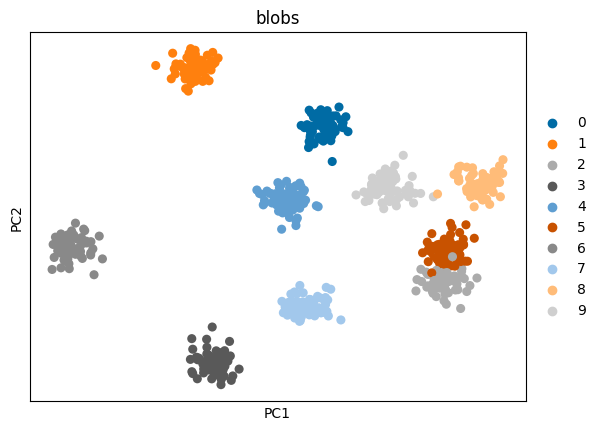

In [3]:
# Scanpy comes with some built-in real and synthetic datasets,
# which can be accessed from the `datasets` namespace
blob_data = sc.datasets.blobs(
    random_state=0,
    n_centers=10,
    n_observations=700,
    n_variables=11
)
display(blob_data)

#sc.pp.log1p(blob_data) # not necessary for this dataset, but feel free to uncomment to see
sc.pp.pca(blob_data)
sc.pl.pca(blob_data, color='blobs')

As you can see from the above plot, this dataset is incredibly simple.  If you'd like to explore it a bit more, such as making a histogram of the counts (to check for Gaussianity, for example), feel free to do so below!

In [4]:
# your code here

We'll now run our GmGM on this dataset.  We would expect, if GmGM is working well, that clusters in the learned graph correspond to the different blobs.  GmGM can take AnnData objects (the standard object used by ScanPy) as input.

GmGM is essentially a two-step process:
1) Jointly learn the dense cell precision matrix and the dense gene precision matrix
2) Apply thresholding to enforce sparsity

There are multiple different ways to threshold, controlled by the `threshold_method` parameter.  I'll list them below for completeness, but no need to memorize them!  **You can skip the explanation of GmGM's parameters, if you wish.**

- "statistical-significance": keep only edges that are statistically significant.  This is the default method.
- "overall": keep only a certain percent of all edges
- "overall-col-weighted": first downweight vertices with lots of edge-weight coming to it, then perform "overall" thresholding.
- "rowwise": keep only a certain percent of each vertex's edges
- "rowwise-col-weighted": first downweight verticies, then perform "rowwise" thresholding
- "nonsingleton-percentage": thresholds using "overall" until there are a certain amount of vertices that have no edges
- "bonferroni": statistical significance with the bonferroni correction

The exact percent to keep (or the p-value cutoff if using statistical-significance/bonferroni) is controlled by the `to_keep` parameter.  You can also pass an integer to `to_keep`, so for example if `to_keep=10` with "rowwise" thresholding, it will keep 10 edges per vertex.  Note that if `to_keep=1` it will be treated as an integer, not a percent - if you want to keep all the edges, use `to_keep=1.0`.

Finally, you can also specify that each vertex should have a minimum degree, using `min_edges`.  AnnData objects, like `blob_data`, call their axes "obs" and "var" (in place of "cell" and "gene", respectively).  For `min_edges` and `to_keep`, you can pass in a dictionary instead of a single number, allowing different thresholding on different axes.  When you intend to cluster with your graphs, I recommend using `min_edges`, as otherwise (especially with "statistical-significance" thresholding) you'll end up with many singleton nodes, making clustering impossible.

In [5]:
blob_data = GmGM.GmGM(
    blob_data,
    to_keep=0.05,
    min_edges={"obs": 5, "var": 3}, # to ensure the graphs have no singletons
)

# The output graphs will be stored in:
# - `blob_data.obsp['obs_gmgm_connectivities']`
# - `blob_data.varp['var_gmgm_connectivities']`
blob_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

`AnnData` objects store graphs in `obsp` and `varp` dictionaries.  Our "cells" are in `obsp`; let's cluster this graph.  We'll use the Leiden clustering algorithm, which is built into scanpy.  It has a `resolution` parameter; smaller resolutions mean less clusters.

/tmp/ipykernel_30120/3298066952.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(blob_data, obsp='obs_gmgm_connectivities', key_added='leiden_gmgm', resolution=0.1)


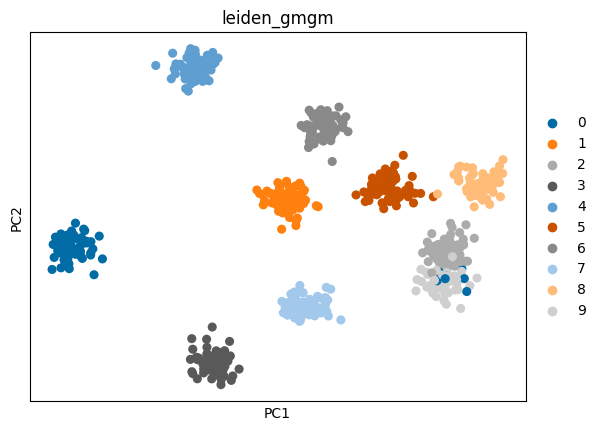

AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs', 'leiden_gmgm'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

In [6]:
# These two lines of code are useful if you accidentally make too many clusters
# Ask me in person if you want an explanation of them; they're not necessary and can be removed.
if 'leiden_gmgm_colors' in blob_data.uns:
    del blob_data.uns['leiden_gmgm_colors']

# Run the clustering on our cell graph, and save it in `blob_data.obs['leiden_gmgm']`
sc.tl.leiden(blob_data, obsp='obs_gmgm_connectivities', key_added='leiden_gmgm', resolution=0.1)

# Display our clustering.
sc.pl.pca(blob_data, color='leiden_gmgm')
blob_data

The recovery seems almost perfect!  Let's confirm numerically that we recover well, by looking at various clustering metrics.  They're all close to 1, implying that our clustering "leiden_gmgm" matches our ground truth "blobs" quite closely.

In [7]:
print("Number of connected components: ", csgraph.connected_components(blob_data.obsp['obs_gmgm_connectivities'])[0])
print(
    metrics.adjusted_rand_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
    metrics.homogeneity_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
    metrics.completeness_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
)

Number of connected components:  9
0.9757706769730835 0.98399743383868 0.9845571379139368


**Bonus Task**: Remember how we talked about different thresholding methods for GmGM?  Try them above and see how they do!  My personal favorite for cell graphs is "rowwise-col-weighted" without `min_edges`, as I think it leads to the most coherent cell graphs.  For genes, if there's enough data then I use "statistical-significance" or "bonferroni" without `min_edges`, however for smaller datasets these graphs are too sparse to be useful; in which case I stick with "rowwise-col-weighted".

---

We've now looked at the performance of GmGM.  It'd be useful to compare it to a baseline, like the graphical lasso (GLasso).  GLasso has two key differences with GmGM:

1) If creating a cell graph, it will assume your genes are independent (and vice-versa)
2) It uses L1 regularization instead of thresholding.

The first difference is the main motivation for GmGM, but for this incredibly simple dataset it won't matter (since the synthetic 'genes' really are independent here - but for the rest of the datasets in this notebook, it will matter).

However, L1 regularization leads to qualitatively different graphs.  In theory, L1 regularization should be better than thresholding (as we're baking the sparsity assumption directly into the learning procedure of the model).  In practice, it typically results in disjoint graphs with many singletons - not ideal for clustering.  If you did the **bonus task** from above, this problem likely shows up when using GmGM with "overall" thresholding as well.  There's nothing fundamentally stopping you from designing a regularizer that mitigates that problem, but it's not included in standard implementations of GLasso.

**Bonus task**: Why does this behavior manifest for GLasso and GmGM with "overall" thresholding?  Don't need a conclusive answer, just spend some time coming up with potential explanations.

---

We'll now run GLasso.  We'll try to make it so that GLasso's graph is as sparse as GmGM's, which will require manual tuning of its regularization parameter.  I've already done this for you.

In [8]:
nonzero = (blob_data.obsp['obs_gmgm_connectivities'] != 0).sum()
print(f"Nonzero elements of GmGM: {nonzero}")

Nonzero elements of GmGM: 7392


In [9]:
# We found this very finnicky to set up, hence our decisions in how to preprocess the data
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = blob_data.X
data = StandardScaler().fit_transform(data)
emp_cov = data @ data.T

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.984525, # manually tuned to give same #nonzero as GmGM
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
print(f"Nonzero elements of GLasso: {(goutput[1] != 0).sum()}")

# Remove diagonal entries
np.fill_diagonal(goutput[1], 0)
blob_data.obsp["obs_glasso_connectivities"] = np.abs(goutput[1])
blob_data

Nonzero elements of GLasso: 7392


AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs', 'leiden_gmgm'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities'
    varp: 'var_gmgm_connectivities'

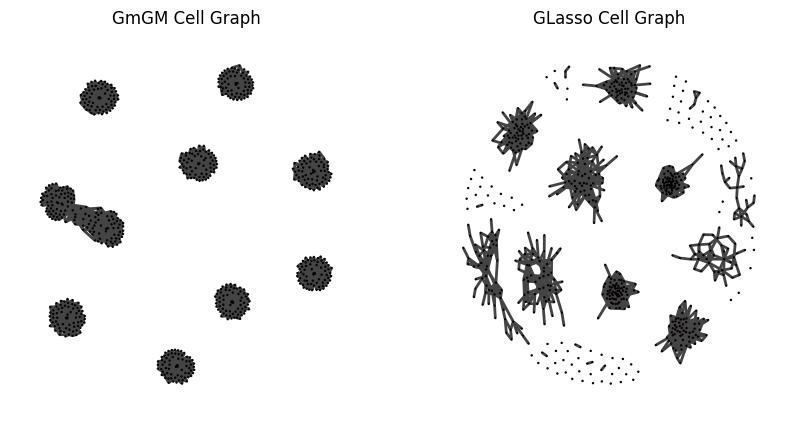

In [10]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

ig.plot(
    ig.Graph.Weighted_Adjacency(blob_data.obsp["obs_gmgm_connectivities"].toarray(), mode="undirected").simplify(),
    target=ax1,
    vertex_size=1
)
ig.plot(
    ig.Graph.Weighted_Adjacency(blob_data.obsp["obs_glasso_connectivities"], mode="undirected"),
    target=ax2,
    vertex_size=1
)

ax1.set_title("GmGM Cell Graph")
ax2.set_title("GLasso Cell Graph")
pass

As mentioned before, GLasso's graph is very disjoint, with many singletons, this will heavily disrupt the ability of the graph to cluster.

In [11]:
print("Number of connected components: ", csgraph.connected_components(blob_data.obsp["obs_glasso_connectivities"])[0])
sc.tl.leiden(blob_data, obsp='obs_glasso_connectivities', key_added='leiden_glasso', resolution=0.1)
print(
    metrics.adjusted_rand_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
    metrics.homogeneity_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
    metrics.completeness_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
)

Number of connected components:  105
0.8480420439341059 1.0 0.7579176886342132


That's all for this section.  Typically we're also interested in the gene graph, but this synthetic dataset is too simple to have any meaningful structure there.  In the next section, we'll look at a more advanced synthetic dataset.

## Part 1b: Advanced synthetic data

The synthetic dataset we'll use in this section aims to simulate the diversification of progenitor cells into a few different cell types (Erythrocytes, Megakaryocytes, Monocytes, and Neutrophils).  It doesn't contain many genes (only 11), but these synthetic genes have been modelled off of real genes and hence should ideally correlate with each other in the same manner that they would in reality.  Furthermore, the data has a "pseudotemporal" structure, i.e. rather than being discrete blobs, there is a continuum of cells in PCA-space.

/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


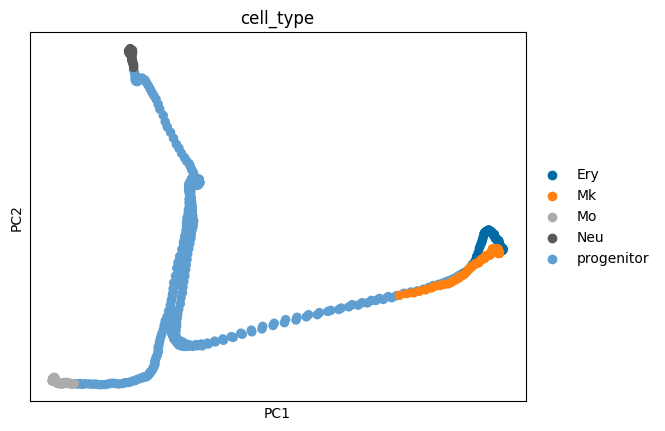

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [12]:
krum_data = sc.datasets.krumsiek11()
sc.pp.pca(krum_data)
sc.pl.pca(krum_data, color='cell_type')
krum_data

Now, let's run GmGM on this dataset.  Take a moment to think about what a "good" graph to describe this data might look like.

In [13]:
# As mentioned in the last section, these are my favorite default settings for GmGM.
# You're free to change these!  In fact, I would recommend doing so to see how
# the parameter choice affects the results.
krum_data = GmGM.GmGM(
    krum_data,
    to_keep={"obs": 5, "var": 3},
    min_edges={"obs": 0, "var": 0},
    threshold_method="rowwise-col-weighted"
)
krum_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

Now that we have our graph, we can cluster.  How do you think the clustering did?

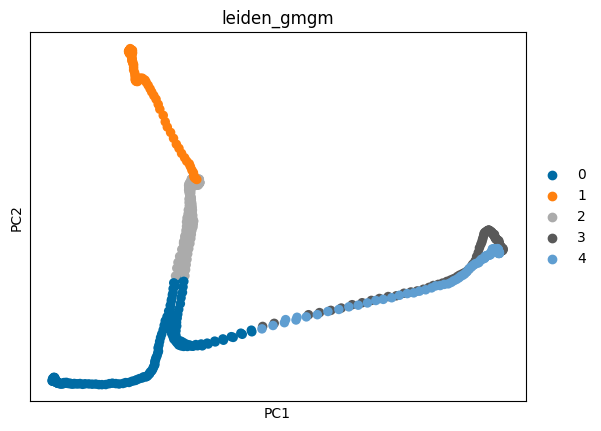

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

In [14]:
if 'leiden_gmgm_colors' in krum_data.uns:
    del krum_data.uns['leiden_gmgm_colors']
sc.tl.leiden(krum_data, obsp='obs_gmgm_connectivities', key_added='leiden_gmgm', resolution=0.1)
sc.pl.pca(krum_data, color='leiden_gmgm')
krum_data

In [15]:
print("Number of connected components: ", csgraph.connected_components(krum_data.obsp['obs_gmgm_connectivities'])[0])
print(
    metrics.adjusted_rand_score(krum_data.obs['cell_type'], krum_data.obs['leiden_gmgm']),
    metrics.homogeneity_score(krum_data.obs['cell_type'], krum_data.obs['leiden_gmgm']),
    metrics.completeness_score(krum_data.obs['cell_type'], krum_data.obs['leiden_gmgm']),
)

Number of connected components:  1
0.3488400832769241 0.6446376942191099 0.5666953106552807


Our metrics for clustering performance are certainly smaller than for the previous dataset, but still decent.  What really matters is how they compare with GLasso.  As before, we'll try to match the sparsities of the two methods.

In [16]:
nonzero = (krum_data.obsp['obs_gmgm_connectivities'] != 0).sum()
print(f"Nonzero elements of GmGM: {nonzero}")

Nonzero elements of GmGM: 6196


In [17]:
# We found this very finnicky to set up, hence our decisions in how to preprocess the data
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = krum_data.X
data = StandardScaler().fit_transform(data)
emp_cov = (data @ data.T).astype(float)

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.99981735, # manually tuned to give same #nonzero as GmGM
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
print(f"Nonzero elements: {(goutput[1] != 0).sum()}")

krum_data.obsp["obs_glasso_connectivities"] = np.abs(goutput[1])
krum_data

Nonzero elements: 6196


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities'
    varp: 'var_gmgm_connectivities'

In [18]:
print("Number of connected components: ", csgraph.connected_components(goutput[1])[0])
sc.tl.leiden(krum_data, obsp='obs_glasso_connectivities', key_added='leiden_glasso', resolution=0.1)
print(
    metrics.adjusted_rand_score(krum_data.obs['cell_type'], krum_data.obs['leiden_glasso']),
    metrics.homogeneity_score(krum_data.obs['cell_type'], krum_data.obs['leiden_glasso']),
    metrics.completeness_score(krum_data.obs['cell_type'], krum_data.obs['leiden_glasso']),
)

Number of connected components:  276
0.003392147830863129 1.0 0.2236756595630382


The metrics of GLasso are much worse, again because of how many singletons it has.  Let's look at some plots to get a better idea.  I've written the function `plot_cells` (in `utilities.py`) to simplify this process for you.

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities'
    varp: 'var_gmgm_connectivities'

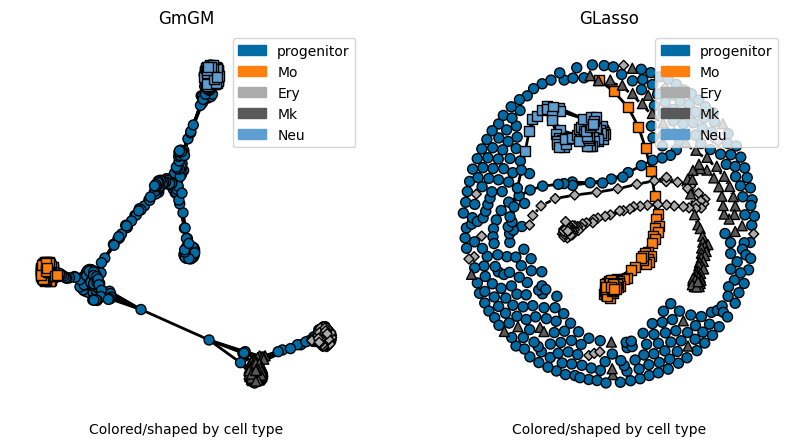

In [19]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1,
   legend_loc='upper right'
)
plot_cells(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
krum_data

What takeaways do you get from these two graphs?  In particular, it's interesting that GmGM seems to be biased against connecting progenitor cells!

---

By this point, you've hopefully gotten used to running GmGM and GLasso, and analyzing the cell graph.  Of course, we still haven't looked at genes...  That'll happen soon :)

But first, let's introduce one last algorithm - the Strong Product.  Here's a comparison of GmGM's Kronecker Sum method, the Strong Product method, and a few others.

0) GLasso - Assumes either the cells or genes are independent.
1) Kronecker Sum/Cartesian Product - Used by GmGM, TeraLasso, and many others.  Assumes genes interact within a cell but not "between cells" (i.e. assumes a gene in cell A never affects the expression of another gene in cell B).
2) Kronecker Product/Tensor Product - Also in common use.  Assumes genes only interact between cells, but never within cells.
3) Strong Product - Assumes genes can interact within and between cells.  [See our recent paper](https://scholar.google.co.uk/citations?view_op=view_citation&hl=en&user=N2VrHeEAAAAJ&citation_for_view=N2VrHeEAAAAJ:WF5omc3nYNoC) for more details.
4) Sylvester Product - Based on a generative process rather than graphical interactions.

In this workshop, we'll only look at [0], [1], and [3].  I'd argue that [2] isn't well-suited for scRNA-seq data, but [4] would be an interesting method for you to try out in your own time!

**Bonus Task:** Of the 5 assumptions listed above, which do you think is most reasonable for scRNA-seq data?

Below, we'll run the strong product model.  Check the file `strong_product_model.py` if you'd like to see the source code for it.  Like GmGM, the strong product model doesn't use L1 regularization, just thresholding.  However, it does use a bit of L2 regularization, which is the source of the `rho` parameters.  In practice, these don't affect the final graph sparsity structure much - but do affect the edge weigths.  Feel free to play around with them, though!

We'll ensure that the strong product results also have the same sparsity as GmGM.

In [20]:
# This may take ~30 seconds
sp_results = strong_product_model(
    krum_data.X,
    rho_rows=1e-3,
    rho_cols_within_rows=1e-3,
    rho_cols_between_rows=1e-3,
    verbose=True,
    tol=1e-8
)

# We have to do the thresholding ourselves for this algorithm
sp_cells = np.abs(sp_results['rows'])
np.fill_diagonal(sp_cells, 0)

# Keep the same amount of edges as from GmGM
to_keep = krum_data.obsp['obs_gmgm_connectivities'].nnz - 640
percentile = 100 - to_keep / 640**2 * 100
threshold = np.percentile(sp_cells, percentile)
sp_cells[sp_cells < threshold] = 0
sp_cells = sparse.csr_array(sp_cells)
krum_data.obsp['obs_sp_connectivities'] = sp_cells

sp_cells

Iteration 0: -3159.514256669987
Iteration 1: -13372.69521627399
Iteration 2: -17133.421266839432


/home/codespace/.local/lib/python3.12/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/codespace/.local/lib/python3.12/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/workspaces/ellis-summerschool/notebooks/strong_product_model.py:287: RuntimeWarning: invalid value encountered in matmul
  Theta = old_Theta @ linalg.expm(-lr * C)
/workspaces/ellis-summerschool/notebooks/strong_product_model.py:317: RuntimeWarning: invalid value encountered in matmul
  Theta = old_Theta @ linalg.expm(-lr * C)


Iteration 3: -17726.80437820772
Iteration 4: -17726.804378207795 (converged)


<Compressed Sparse Row sparse array of dtype 'float64'
	with 6196 stored elements and shape (640, 640)>

Let's plot the results as before.  Plotting will take up to ~30 seconds.

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities'

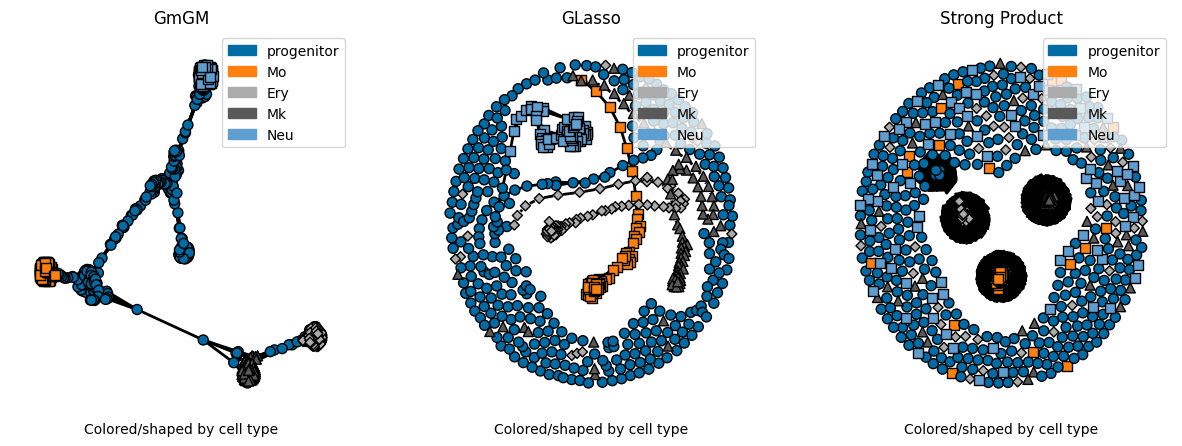

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Strong Product",
   krum_data,
   layout='fr',
   graph_type='obs_sp_connectivities',
   fig=fig,
   ax=ax3
)
krum_data

Interestingly, all methods have their own pros and cons.

1) GmGM does the best at capturing the global structure.
2) GLasso's "linearity" in the graph implies it's doing a good job capturing the local structure _in the regions where it has edges_, but it systemically fails to connect progenitors (blue circles), leading to lots of singletons and a poor global structure.
3) The Strong Product does a great job tightly clustering cells of the same type, but does not capture any temporal information.

This difference could be down to the different assumptions they make about gene interactions, or down to differences in thresholding/regularization.  The only way to know for sure will be for you to experiment ;) But if you don't have much time left, then keep progressing with the workshop and come back to this at the end. 

Here's one metric that I used to quite like but have soured a bit on: _assortativity_.  This measures the tendency of cells to connect to others of the same type.  If the assortativity is 1, then cells only connect to others of the same type.  If the assortativity is -1, then the opposite is true.

In [22]:
gmgm_graph = ig.Graph.Weighted_Adjacency(
    krum_data.obsp['obs_gmgm_connectivities'].toarray(),
    mode="undirected"
)
gmgm_graph.vs['cell_type'] = krum_data.obs['cell_type'].astype("category").cat.codes.tolist()
print(
    "GmGM Assortativity: ",
    gmgm_graph.assortativity_nominal('cell_type')
)

glasso_graph = ig.Graph.Weighted_Adjacency(
    krum_data.obsp['obs_glasso_connectivities'],
    mode="undirected"
)
glasso_graph.vs['cell_type'] = krum_data.obs['cell_type'].astype("category").cat.codes.tolist()
print(
    "GLasso Assortativity: ",
    glasso_graph.assortativity_nominal('cell_type')
)

sp_graph = ig.Graph.Weighted_Adjacency(
    krum_data.obsp['obs_sp_connectivities'].toarray() + krum_data.obsp['obs_sp_connectivities'].toarray().T,
    mode="undirected"
)
sp_graph.vs['cell_type'] = krum_data.obs['cell_type'].astype("category").cat.codes.tolist()
print(
    "Strong Product Assortativity: ",
    sp_graph.assortativity_nominal('cell_type')
)

GmGM Assortativity:  0.8136210343596638
GLasso Assortativity:  0.9984605799295017
Strong Product Assortativity:  1.0


Why do you think I've soured on assortativity as a metric?  Should GmGM really be in last place here?

Assortativity prioritizes local structure, and does not care about the edges that aren't there, only the edges that are there.  Locally, GLasso and the strong product do very well - a cell is almost always connected to another of the same type.  However, they've completely failed to capture the global structure of the data!  While GLasso has some evidence of recovering pseudotime, it completely breaks down for progenitor cells.

Given that GLasso systemically breaks down for progenitors, let's look at what happens when we remove the progenitors from the plot.

Text(0.5, 0.98, 'Without Progenitor Cells')

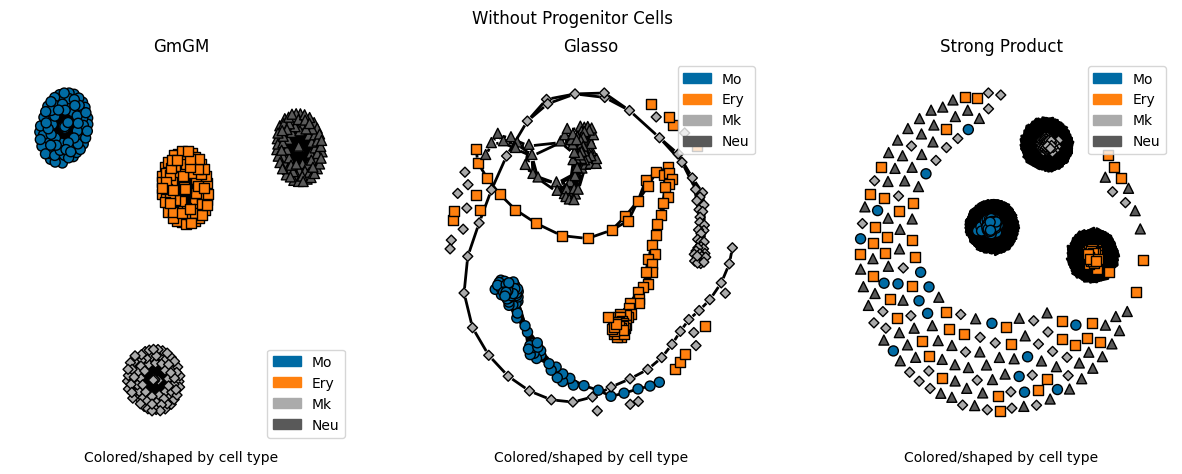

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
plot_cells(
   "GmGM",
   krum_data[krum_data.obs['cell_type'] != 'progenitor'],
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1,
   legend_loc='lower right'
)
plot_cells(
   "Glasso",
   krum_data[krum_data.obs['cell_type'] != 'progenitor'],
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Strong Product",
   krum_data[krum_data.obs['cell_type'] != 'progenitor'],
   layout='fr',
   graph_type='obs_sp_connectivities',
   fig=fig,
   ax=ax3
)
fig.suptitle("Without Progenitor Cells")

GmGM's graph becomes perfectly separated into the remaining cell types!  This indicates that the only "incorrect" edges (from assortativity's perspective) are those between progenitors and other cell types; but these edges aren't necessarily bad at all - progenitors morph into the other cell types as we traverse pseudotime, so such connections exist in the real data itself.

While that's certainly a win for GmGM, once progenitors are removed each cell type clumps together in a blob - the pseudotime information is lost!  GLasso, for what it's worth, seems to have preserved pseudotime through the linear nature of its graphs.

For completeness, below we can see what happens if we look _only_ at progenitors.

Text(0.5, 0.98, 'Just Progenitor Cells')

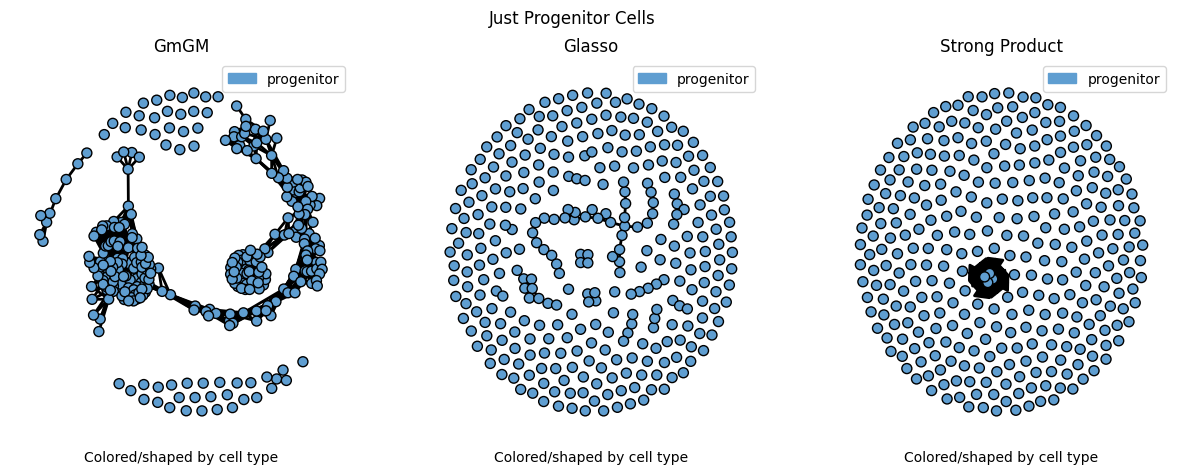

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
plot_cells(
   "GmGM",
   krum_data[krum_data.obs['cell_type'] == 'progenitor'],
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "Glasso",
   krum_data[krum_data.obs['cell_type'] == 'progenitor'],
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Strong Product",
   krum_data[krum_data.obs['cell_type'] == 'progenitor'],
   layout='fr',
   graph_type='obs_sp_connectivities',
   fig=fig,
   ax=ax3
)
fig.suptitle("Just Progenitor Cells")

I've alluded to GmGM capturing global structure, but how do we actually know it's correct?  Let's overlay our graph on top of our PCA plots from earlier to verify the structure is coherent.

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities'

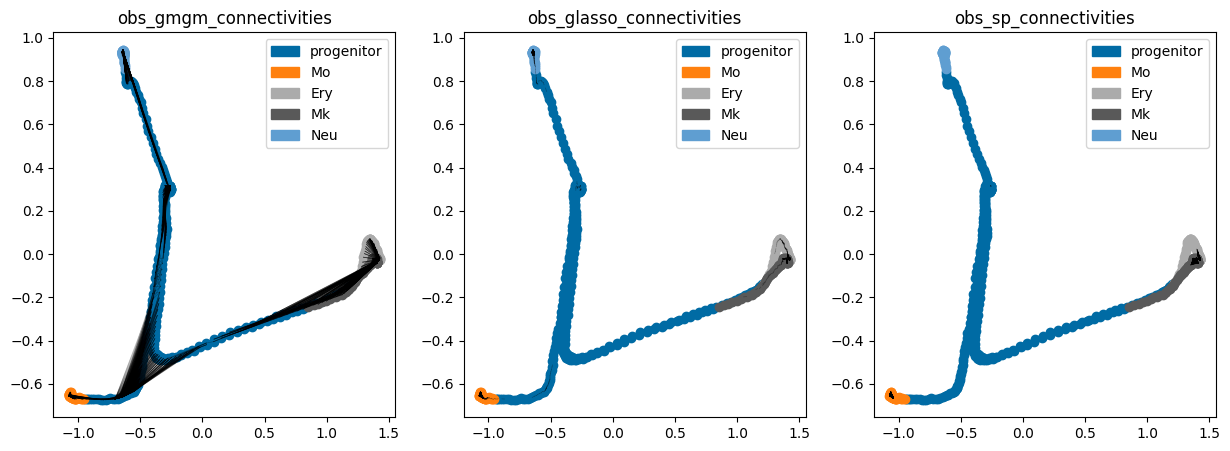

In [25]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_glasso_connectivities", "obs_sp_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

We can see that GmGM has broadly followed the structure of the data in PCA-space.  GLasso's edges are all tightly concentrated at the ends of PCA-space, but we can also see that these edges are _very_ accurate!  In contrast, GmGM does have a few edges that seem to skip across to other parts of the space.

### Genes

So far, we've only looked at cell graphs.  The whole point of using multi-axis models is that you get **both the cell and gene graphs**!  In this simulated dataset, there are only 11 genes - typical datasets before pre-processing have ~20,000.  For the workshop, this is a bit of a blessing - it's a lot easier to plot graphs with only 11 genes!

First, we need to do two quick things:
1) We need to run GLasso on the gene axis, since GLasso only learns one graph at a time
2) Strong Product is like GmGM (both axes are learned jointly), so we just need to threshold its gene graphs

As before, we'll match their sparsity levels to GmGM for a fair comparison.

In [26]:
print(
    f"GmGM nonzero edges: {krum_data.varp['var_gmgm_connectivities'].nnz}"
)

GmGM nonzero edges: 53


Now, we'll threshold the strong product's gene graphs.  The strong product produces two different gene graphs, one for within-cell interactions and another for between-cell interactions.

In [27]:
# We have to do the thresholding ourselves for this algorithm
sp_genes1 = np.abs(sp_results['cols_within_rows'])
np.fill_diagonal(sp_genes1, 0)

# Keep the same amount of edges as from GmGM
to_keep = krum_data.varp['var_gmgm_connectivities'].nnz - 11
percentile = 100 - to_keep / 11**2 * 100
threshold = np.percentile(sp_genes1, percentile)
sp_genes1[sp_genes1 < threshold] = 0
sp_genes1 = sparse.csr_array(sp_genes1)
krum_data.varp['var_sp_within_connectivities'] = sp_genes1 + sp_genes1.T

# We have to do the thresholding ourselves for this algorithm
sp_genes2 = np.abs(sp_results['cols_between_rows'])
np.fill_diagonal(sp_genes2, 0)

# Keep the same amount of edges as from GmGM
to_keep = krum_data.varp['var_gmgm_connectivities'].nnz - 11
percentile = 100 - to_keep / 11**2 * 100
threshold = np.percentile(sp_genes2, percentile)
sp_genes2[sp_genes2 < threshold] = 0
sp_genes2 = sparse.csr_array(sp_genes2)
krum_data.varp['var_sp_between_connectivities'] = sp_genes2 + sp_genes2.T

And now, let's run GLasso on the genes.  Ironically, GLasso will assume that the cells are independent when doing this, even though just a few codeblocks ago we were completely invested in analyzing the conditional dependency structure of the cells!

In [28]:
# We found this very finnicky to set up, hence our decisions in how to preprocess the data
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = krum_data.X.T
data = StandardScaler().fit_transform(data)
emp_cov = (data @ data.T).astype(float)

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.505, # manually tuned to give same #nonzero as GmGM
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
print(f"Nonzero elements: {(goutput[1] != 0).sum()}")

krum_data.varp["var_glasso_connectivities"] = np.abs(goutput[1])
krum_data

Nonzero elements: 53


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities'

Just like the helper function `plot_cells` in `utilities.py`, I've also given you a `plot_genes` function in that same file.  We can use that to visually inspect our learned gene graphs.

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities'

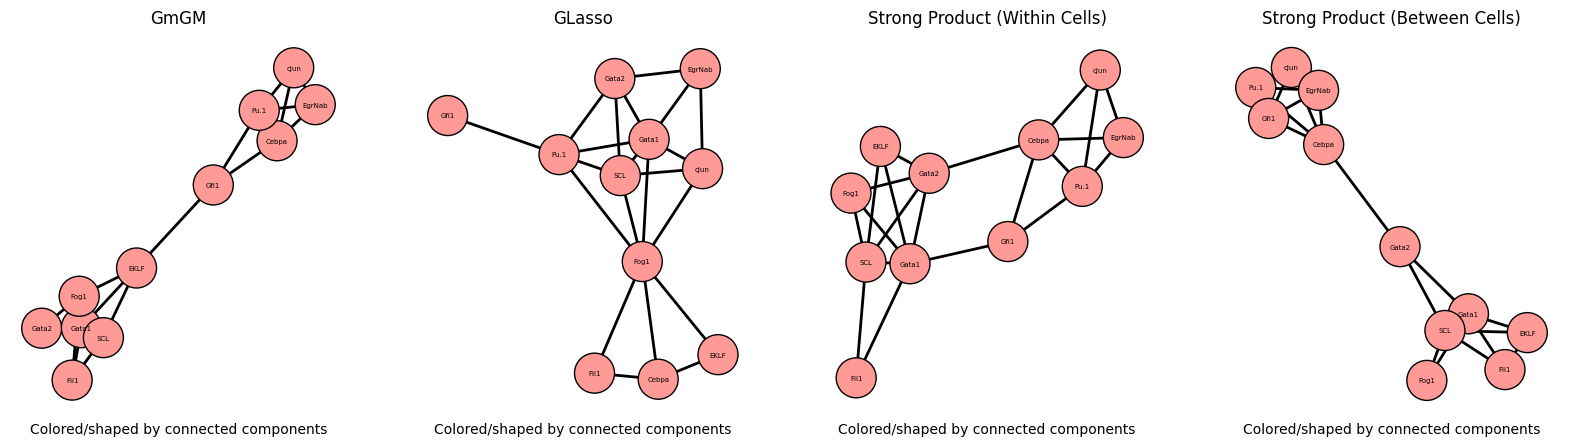

In [29]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_genes(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_genes(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig
)
plot_genes(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig
)
plot_genes(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig
)
krum_data

Recall that GmGM assumes genes only interact within cells, not between them.  _A priori_ we would expect GmGM to then look more like the within-cell graph of the strong product.  Visually, it actually looks quite a bit like the between-cell graph!  However, this could easily be due to the plotting algorithm placing the nodes in similar places, so we should use some objective metrics to check this before jumping to conclusions.

Conceptually, we can think of a graph as a set of edges (and a set of vertices).  To measure similarity, we can rely on classic measures of similarity between sets.  In particular, we'll use Jaccard and Dice similarity scores on the edge sets.

/tmp/ipykernel_30120/48804810.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_30120/48804810.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))
/tmp/ipykernel_30120/48804810.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_30120/48804810.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))


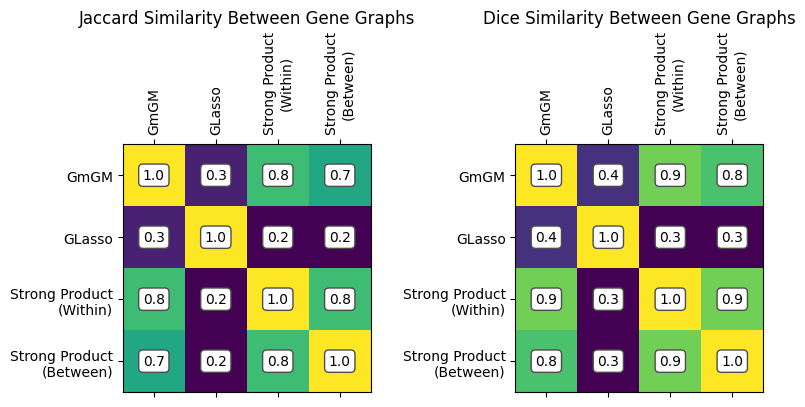

In [30]:
genes_gmgm = ig.Graph.Weighted_Adjacency(krum_data.varp["var_gmgm_connectivities"].toarray())
genes_glasso = ig.Graph.Weighted_Adjacency(krum_data.varp["var_glasso_connectivities"])
genes_sp_within = ig.Graph.Weighted_Adjacency(krum_data.varp["var_sp_within_connectivities"].toarray())
genes_sp_between = ig.Graph.Weighted_Adjacency(krum_data.varp["var_sp_between_connectivities"].toarray())

allgraphs = {
    "GmGM": genes_gmgm,
    "GLasso": genes_glasso,
    "Strong Product\n(Within)": genes_sp_within,
    "Strong Product\n(Between)": genes_sp_between
}
similarities = np.zeros((4, 4, 2))
for (i1, (t1, g1)), (i2, (t2, g2)) in itertools.product(enumerate(allgraphs.items()), enumerate(allgraphs.items())):
    e1 = set(g1.get_edgelist())
    e2 = set(g2.get_edgelist())
    similarities[i1, i2, 0] = len(e1 & e2) / len(e1 | e2)
    similarities[i1, i2, 1] = 2 * len(e1 & e2) / (len(e1) + len(e2))

fig, axs = plt.subplots(figsize=(8, 4), ncols=2)

for i, ax in enumerate(axs):
    ax.matshow(similarities[:, :, i])
    ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
    ax.set_yticklabels([""] + list(allgraphs.keys()))

    for (i, j), z in np.ndenumerate(similarities[:, :, i]):
        ax.text(
            i, j,
            '{:0.1f}'.format(z),
            ha='center',
            va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
        )
    
axs[0].set_title("Jaccard Similarity Between Gene Graphs")
axs[1].set_title("Dice Similarity Between Gene Graphs")
fig.tight_layout()
pass

Contrary to visual inspection, it seems that GmGM is indeed more similar to the strong product's within-cell graph (just as intuition would predict!).  All graphs are generally fairly similar, except for GLasso which is the odd one out.

As a brief diversion, let's do this same check on the cell graphs.  Just for fun, we'll thrown in the K-nearest-neighbors graph too!

/tmp/ipykernel_30120/1728425766.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_30120/1728425766.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))
/tmp/ipykernel_30120/1728425766.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_30120/1728425766.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))


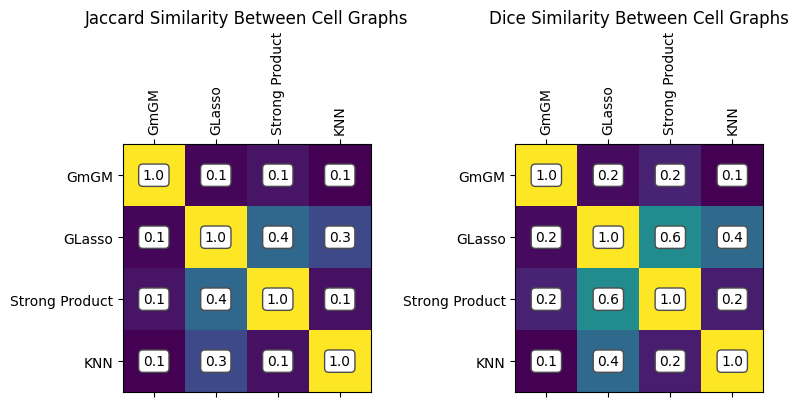

In [31]:
# For K Nearest Neighbors
sc.pp.neighbors(krum_data, n_neighbors=int(krum_data.obsp['obs_gmgm_connectivities'].nnz / 640))
krum_data.obsp['connectivities']

cells_gmgm = ig.Graph.Weighted_Adjacency(krum_data.obsp["obs_gmgm_connectivities"].toarray())
cells_glasso = ig.Graph.Weighted_Adjacency(krum_data.obsp["obs_glasso_connectivities"])
cells_sp = ig.Graph.Weighted_Adjacency(krum_data.obsp["obs_sp_connectivities"].toarray())
cells_knn = ig.Graph.Weighted_Adjacency(krum_data.obsp["connectivities"].toarray())

allgraphs = {
    "GmGM": cells_gmgm,
    "GLasso": cells_glasso,
    "Strong Product": cells_sp,
    "KNN": cells_knn
}
similarities = np.zeros((4, 4, 2))
for (i1, (t1, g1)), (i2, (t2, g2)) in itertools.product(enumerate(allgraphs.items()), enumerate(allgraphs.items())):
    e1 = set(g1.get_edgelist())
    e2 = set(g2.get_edgelist())
    similarities[i1, i2, 0] = len(e1 & e2) / len(e1 | e2)
    similarities[i1, i2, 1] = 2 * len(e1 & e2) / (len(e1) + len(e2))

fig, axs = plt.subplots(figsize=(8, 4), ncols=2)

for i, ax in enumerate(axs):
    ax.matshow(similarities[:, :, i])
    ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
    ax.set_yticklabels([""] + list(allgraphs.keys()))

    for (i, j), z in np.ndenumerate(similarities[:, :, i]):
        ax.text(
            i, j,
            '{:0.1f}'.format(z),
            ha='center',
            va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
        )
    
axs[0].set_title("Jaccard Similarity Between Cell Graphs")
axs[1].set_title("Dice Similarity Between Cell Graphs")
fig.tight_layout()
pass

Okay, back to genes.  We've looked at the similarities of our results, but not the quality of our results!  One way to measure quality is to ensure that similar genes are connected.  In the next code block, I've hand-labeled "marker genes" for each non-progenitor cell type, based on their expression profiles on the PCA plot.  Typically we'd actually consult a list of pre-curated marker genes but this ad-hoc method works for our purposes here in the workshop.

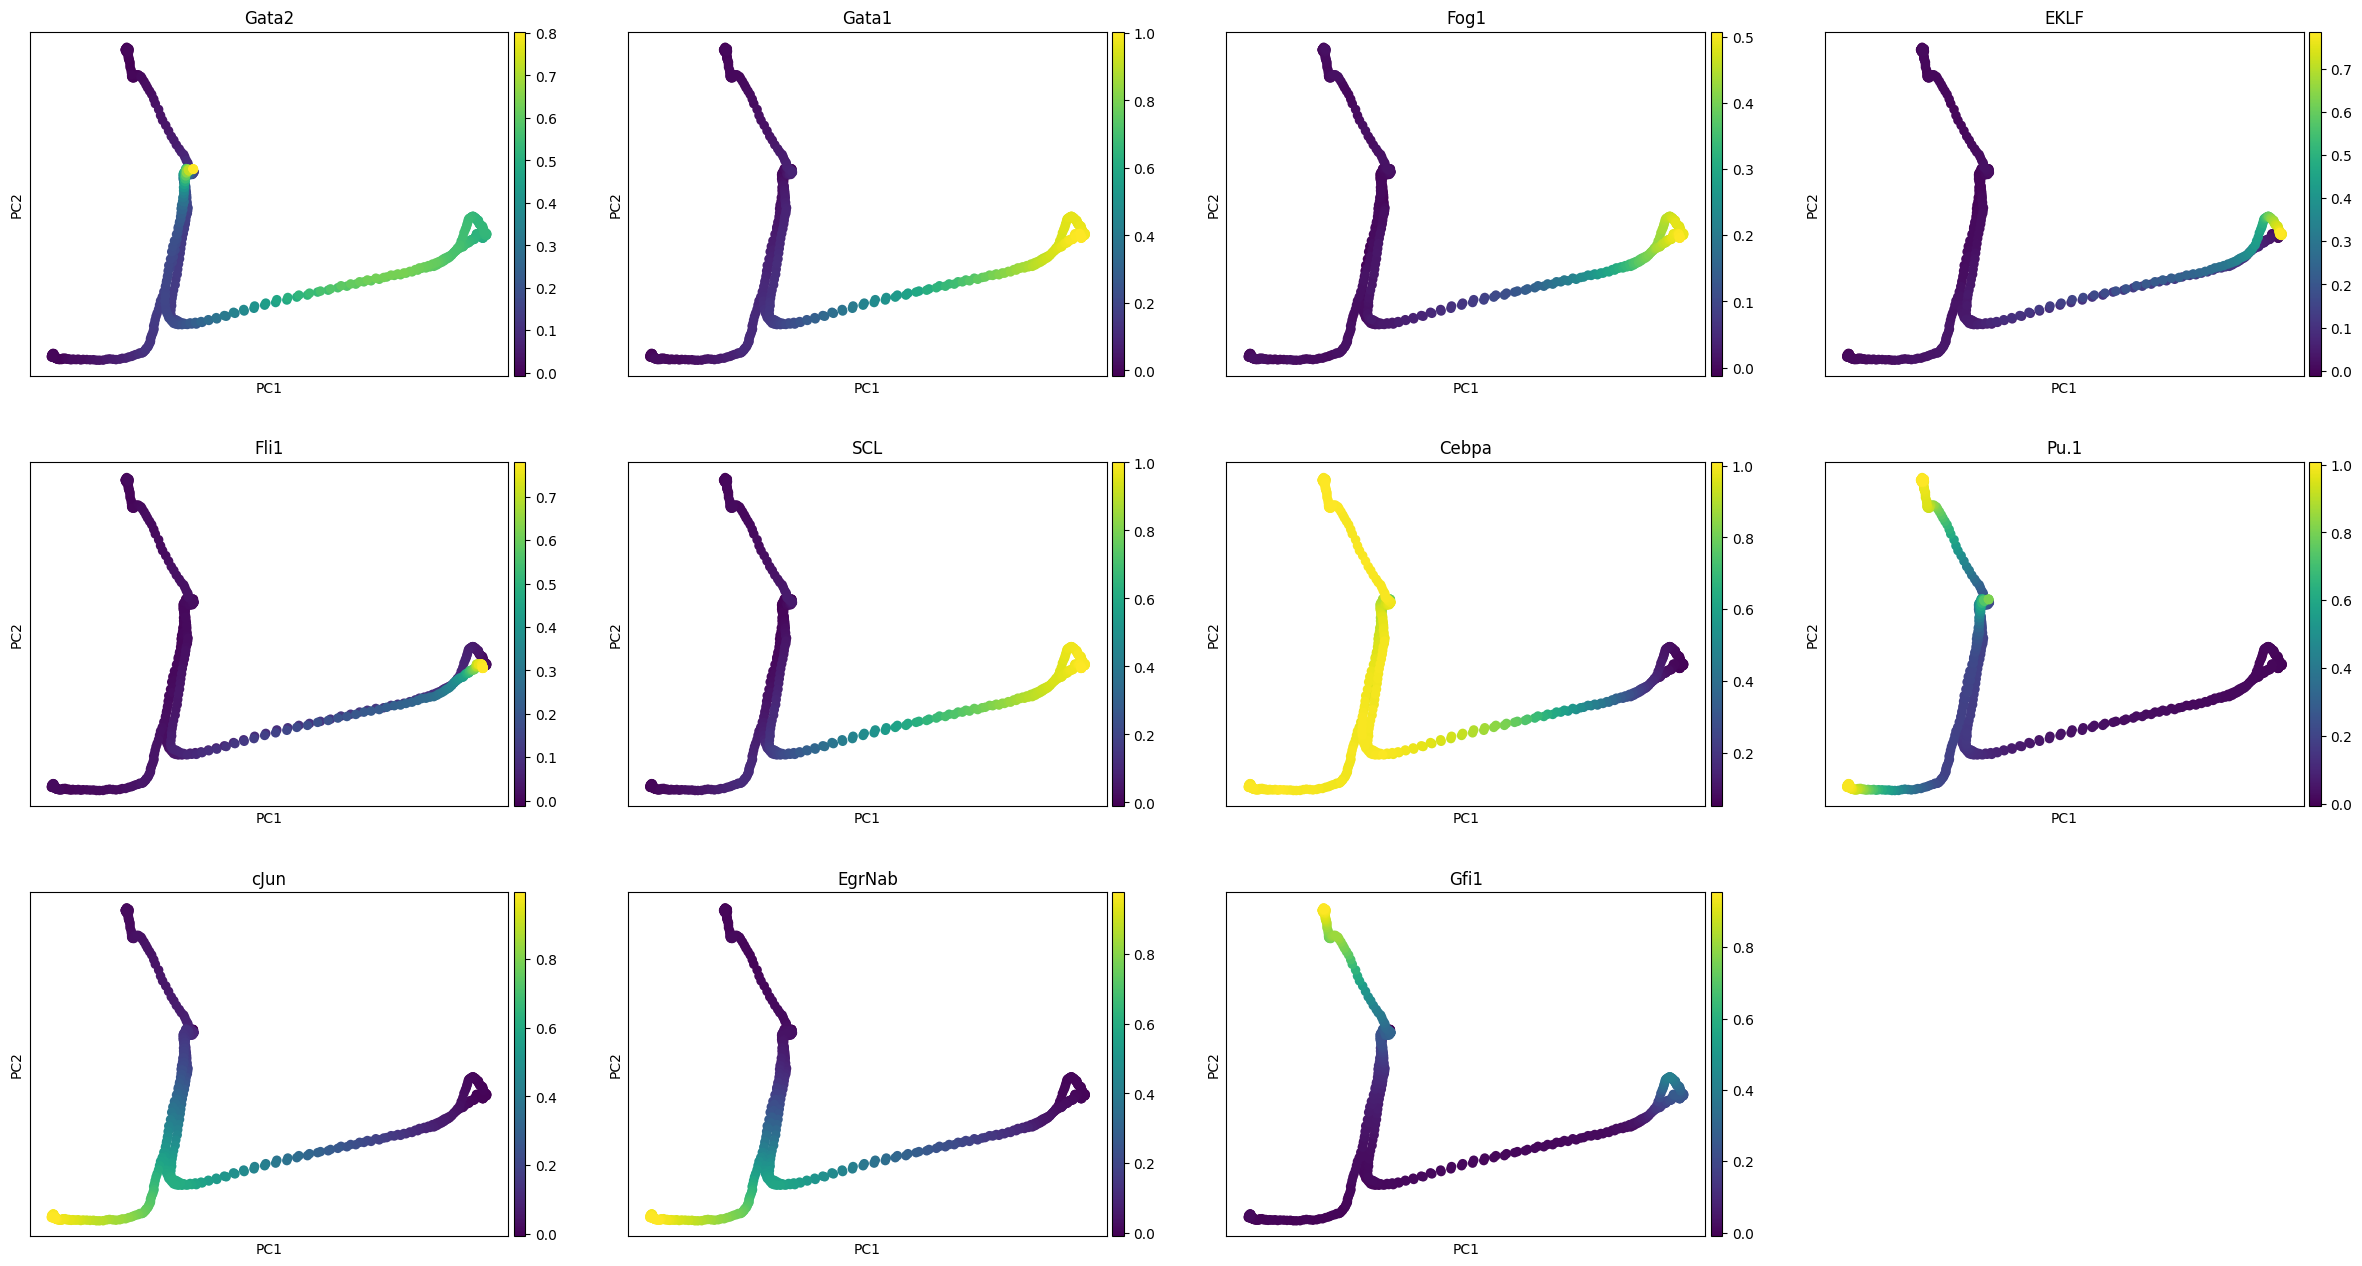

In [32]:
# Display expression profiles of all 11 genes in the dataset.
sc.pl.pca(krum_data, color=list(krum_data.var_names))

# Use this information to create ad-hoc marker genes
krum_data.var["Mo_genes"] = [False, False, False, False, False, False, True, True, True, True, False]
krum_data.var["Ery_genes"] = [True, True, True, True, False, True, False, False, False, False, False]
krum_data.var["Mk_genes"] = [True, True, True, False, True, True, False, False, False, False, False]
krum_data.var["Neu_genes"] = [False, False, False, False, False, False, True, True, False, False, True]

We can now go through every cell's marker genes and inspect whether they tend to cluster together.

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Mo_genes'>)

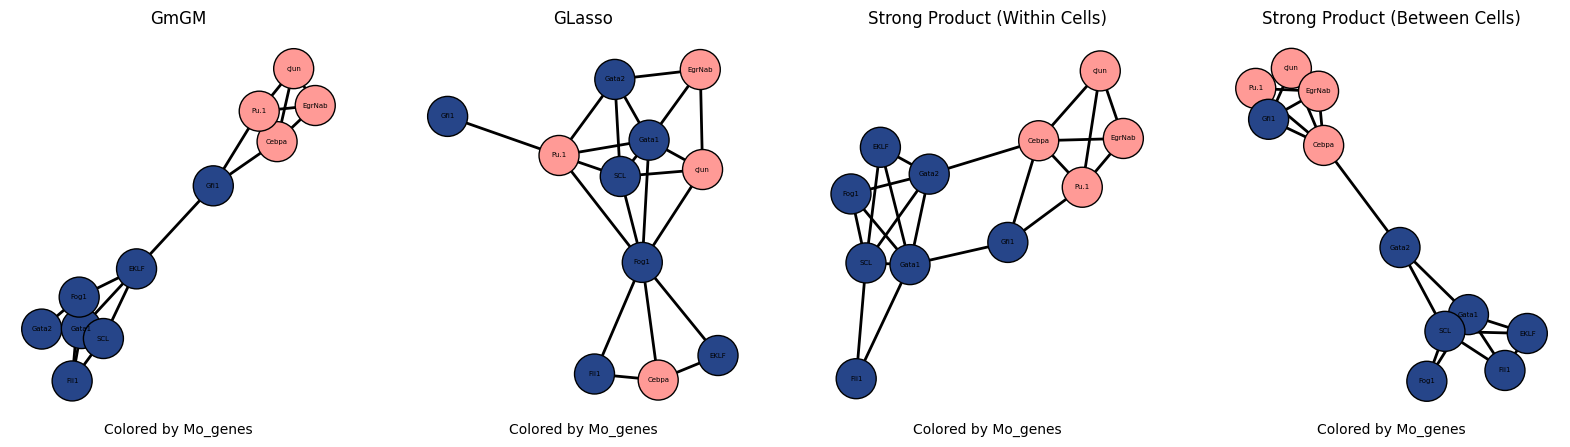

In [33]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_genes(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Mo_genes'
)
plot_genes(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Mo_genes'
)
plot_genes(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Mo_genes'
)
plot_genes(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Mo_genes'
)

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Ery_genes'>)

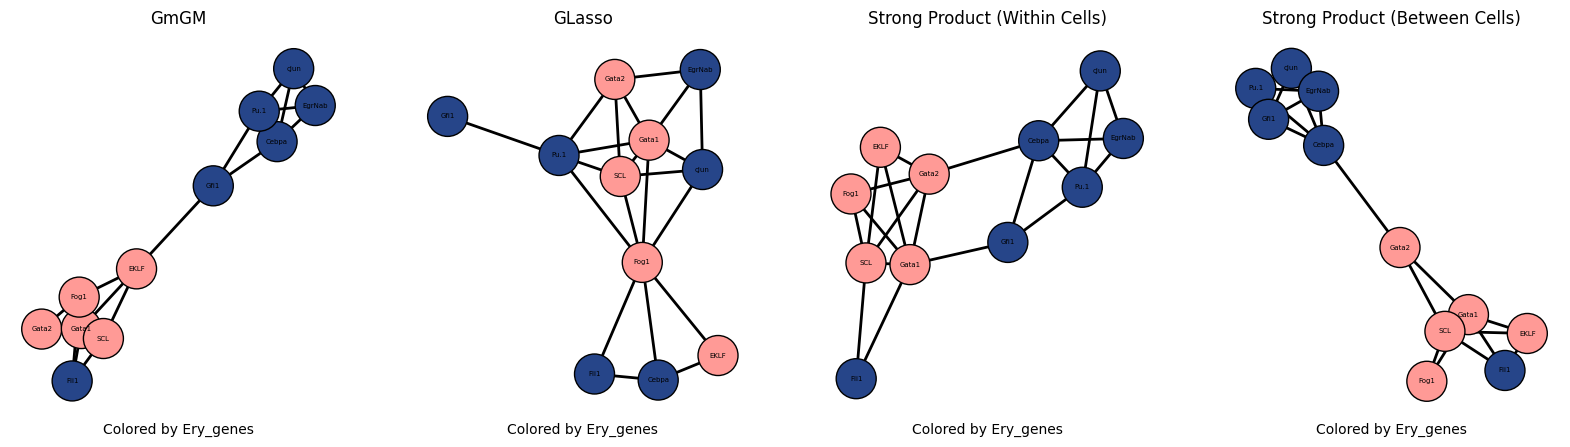

In [34]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_genes(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Ery_genes'
)
plot_genes(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Ery_genes'
)
plot_genes(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Ery_genes'
)
plot_genes(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Ery_genes'
)

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Mk_genes'>)

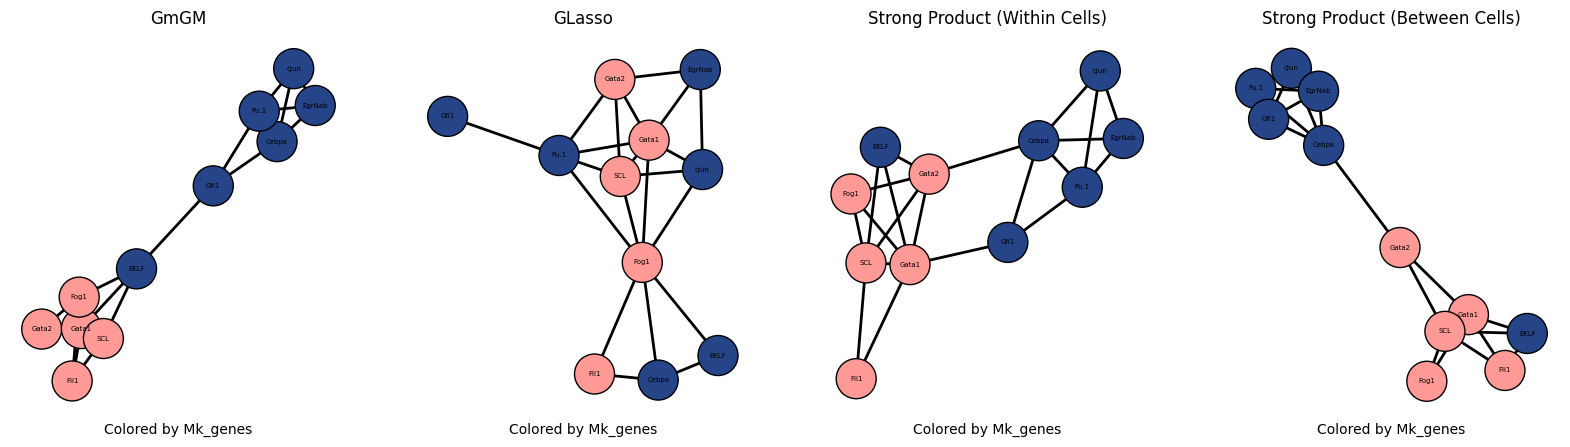

In [35]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_genes(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Mk_genes'
)
plot_genes(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Mk_genes'
)
plot_genes(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Mk_genes'
)
plot_genes(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Mk_genes'
)

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Neu_genes'>)

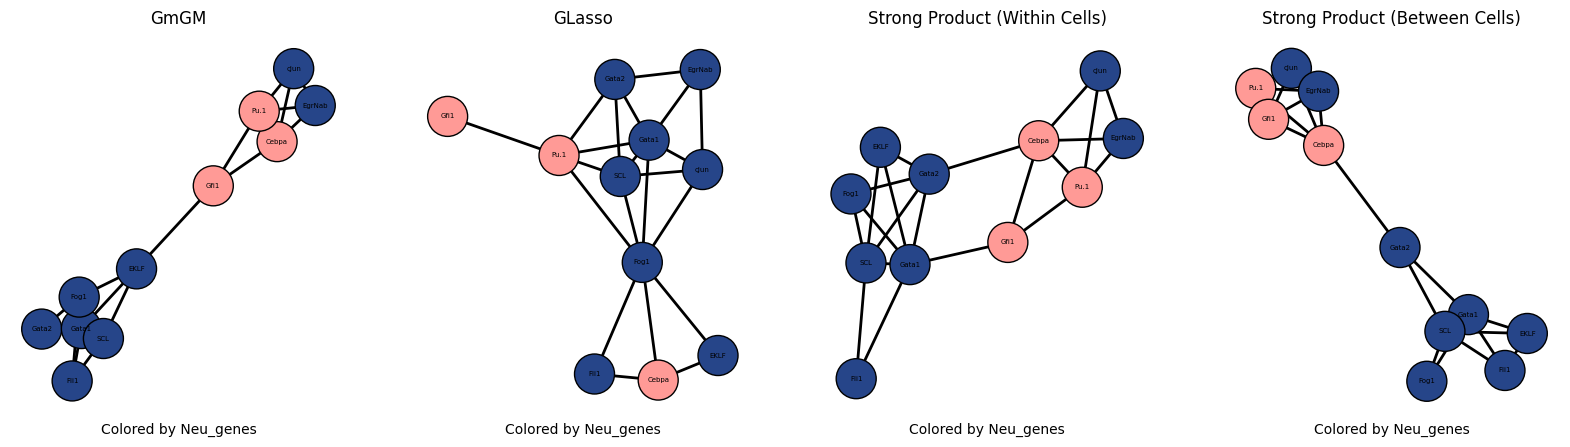

In [36]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_genes(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Neu_genes'
)
plot_genes(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Neu_genes'
)
plot_genes(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Neu_genes'
)
plot_genes(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Neu_genes'
)

Visually, it seems like the non-GLasso methods are doing a pretty good job!  But we really want to put a metric to it to be sure.  Here's an easy test we can do, using the 5 Megakaryocyte markers as an example:

1) Measure the density of the connections between the 5 markers
2) Measure the density of the connections between 5 random genes in the graph

If we repeat step [2] for many random choices, we can come up with p-values measuring how surprising it is under the null hypothesis (null hypothesis = "the 5 markers are no more/less densely connected than 5 random genes") for the marker genes to be so densely connected.

Below is the function we'll use to calculate this.

In [37]:
def get_gene_cluster_statistics(
    graph: ig.Graph,
    gene_cluster: str
) -> tuple[float, float, float, float]:
    np.random.seed(0)

    cluster_density = graph.subgraph(np.arange(11)[krum_data.var[gene_cluster]]).density()

    results = np.zeros(1000)
    for i in range(results.shape[0]):
        # Randomly pick elements
        num_elem = krum_data.var[gene_cluster].sum()
        randoms = np.random.choice(np.arange(11), size=num_elem, replace=False)
        results[i] = graph.subgraph(randoms).density()

    rand_low = np.quantile(results, 0.05)
    rand_high = np.quantile(results, 0.95)
    rand_median = np.quantile(results, 0.5)
    return (
        cluster_density,
        rand_low,
        rand_high,
        rand_median
    )

In the plot below, we've done a heatmap showing the densities of each marker geneset in each graph.  Each pair is labeled with numbers in the form:

A
(B/C/D)

where:

* A = density of marker genes
* C = median density of 5 random genes
* B/D = 5%/95% quantiles of density of 5 random genes

/tmp/ipykernel_30120/3013649926.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_30120/3013649926.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + cluster_types)


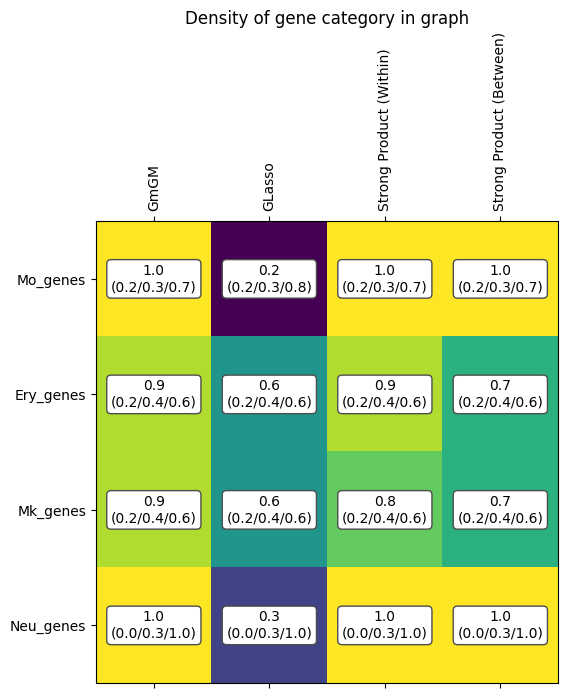

In [38]:
allgraphs = {
    "GmGM": ig.Graph.Weighted_Adjacency(krum_data.varp['var_gmgm_connectivities'].toarray(), mode="undirected"),
    "GLasso": ig.Graph.Weighted_Adjacency(krum_data.varp['var_glasso_connectivities'], mode="undirected"),
    "Strong Product (Within)": ig.Graph.Weighted_Adjacency(krum_data.varp['var_sp_within_connectivities'].toarray(), mode="undirected"),
    "Strong Product (Between)": ig.Graph.Weighted_Adjacency(krum_data.varp['var_sp_between_connectivities'].toarray(), mode="undirected")
}
cluster_types = ['Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes']

gcs = np.zeros((len(allgraphs), len(cluster_types), 4))

for i, (name, graph) in enumerate(allgraphs.items()):
    for j, cluster in enumerate(cluster_types):
        gcs[i, j] = get_gene_cluster_statistics(graph, cluster)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(gcs[:, :, 0].T)
ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
ax.set_yticklabels([""] + cluster_types)

for (i, j), v in np.ndenumerate(gcs[:, :, 0]):
    v, l, h, m = gcs[i, j]
    ax.text(i, j, '{:0.1f}\n({:0.1f}/{:0.1f}/{:0.1f})'.format(v, l, m, h), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_title("Density of gene category in graph")

pass


From above, we can see that GmGM does the best by this metric, with GLasso trailing far behind.  None of GLasso's marker genesets were statistically significant, whereas all other algorithms had all their genesets be statistically significantly dense (except for the neutrophil geneset, for which the 95% quantile was "100% dense" and hence statistical significance is impossible - but in this case, they were all 100% dense).

**This concludes Part 1 of the workshop**.  I did not tune any of the parameters of the algorithms (I used defaults for GmGM that have served me well in other projects) beyond forcing them all to have the same sparsity as GmGM.  As an excercise to you, try tuning the various algorithms to get better performance.  This can be as simple as changing the hyperparameters, or it could involve you writing your own thresholding algorithms (for GmGM or the strong product).

In the next section, we'll look at some more advanced features of GmGM, before moving on to look at a real dataset in the final section.

In [39]:
# your code here

# Part 2: Unlocking the most out of GmGM

There are four drawbacks to the way we have used GmGM so far:

1) It assumes our expression level is 0 on average (Zero-mean assumption).
2) It assumes our data is Gaussian-distributed
3) It is not scalable to tens of thousands of cells
4) It uses thresholding rather than regularization

Drawback [4] was a conscious choice to enhance scalability; TeraLasso makes all the same theoretical assumptions as GmGM, but is compatible with many regularizers (L1, SCAD, MCP, ...).  As a drawback, TeraLasso is slower.  TeraLasso has not been implemented in Python, but rather in [Matlab](https://github.com/kgreenewald/teralasso), so we won't experiment with it during this workshop.

The rest of the drawbacks each have solutions, which we'll explore here.

To address drawback [1], we created a wrapper around Kronecker sum algorithms (such as GmGM and TeraLasso) that allows the correct graph to be found even without making the zero-mean assumption. For details, see the paper [Gaussian Graphical Modelling Without Independence Assumptions for Uncentered Data](https://scholar.google.co.uk/citations?view_op=view_citation&hl=en&user=N2VrHeEAAAAJ&citation_for_view=N2VrHeEAAAAJ:ufrVoPGSRksC).  Eventually, we'll embed this wrapper inside the GmGM package, but for now we've implemented it in the file `mean_wrapper.py`.  We'll give an example below of how to use it with GmGM - but it can be used with any Kronecker-sum algorithm.

In [40]:
# This is a different way to specify inputs to GmGM, rather than feeding it an AnnData or MuData object.
# We'll explain this format a bit more later, but essentially we are saying that our input is a
# matrix (krum_data.X) whose "structure" is that rows represent cells and columns represent genes.
dataset_gmgm_noncentral = GmGM.Dataset(
    dataset={'data': krum_data.X},
    structure={'data': (f'cell', f'gene')},
    batch_axes=None
)

# This jerry-rigs the outputs of gmgm to be in the form
# expected by NoncentralKS
def gmgm_estimator(data):
    # We won't threshold yet, since that will confuse the wrapper
    # Instead, we wait until the end.
    output = GmGM.GmGM(
        data,
        to_keep=0.5,
        #min_edges={"cell": 5, "gene": 3},
    )
    return output.precision_matrices

# We specify our initial values - the mean is initialized to zero
# and the precision matrices/graphs are initialized to the identity matrix
NKS = NoncentralKS(
    gmgm_estimator,
    ({"gene": np.zeros(11), "cell": np.zeros(640)}, 0),
    {"gene": np.eye(11), "cell": np.eye(640)},
)
class result_container:
    # Jerry-rigged class to hold the result
    def __init__(self, precmats):
        self.precision_matrices = precmats

means_gmgm_noncentral, results_gmgm_noncentral = NKS.fit(
    dataset_gmgm_noncentral,
    verbose=True,
    tol=1e-10,
    max_iter=100
)
results_gmgm_noncentral

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


Iteration: 1 (Change: 30.302449074475756)
Iteration: 2 (Change: 1.315796971321106)
Iteration: 3 (Change: 0.04296046495437622)
Iteration: 4 (Change: 0.0020505639258772135)
Iteration: 5 (Change: 0.00010210870823357254)
Iteration: 6 (Change: 5.24017377756536e-06)
Iteration: 7 (Change: 2.9107010846018966e-07)
Iteration: 8 (Change: 6.912878092180108e-08)
Iteration: 9 (Change: 6.25852658586723e-09)
Iteration: 10 (Change: 1.453745457347111e-09)
Converged in 11 iterations
Iteration: 11 (Change: 6.280369727251149e-16)


{'cell': <Compressed Sparse Row sparse array of dtype 'float32'
 	with 409600 stored elements and shape (640, 640)>,
 'gene': <Compressed Sparse Row sparse array of dtype 'float32'
 	with 121 stored elements and shape (11, 11)>}

Annoyingly, we'll have to threshold the data ourselves.

In [41]:
# Add results to our data
cells = np.abs(results_gmgm_noncentral['cell'].toarray())
cells /= cells.mean(axis=0)
quantile = np.quantile(cells, 1-krum_data.obsp['obs_gmgm_connectivities'].nnz/640**2)
cells[cells < quantile] = 0
krum_data.obsp['obs_nks_gmgm_connectivities'] = cells + cells.T

genes = np.abs(results_gmgm_noncentral['gene'].toarray())
genes /= genes.mean(axis=0)
quantile = np.quantile(genes, 1-krum_data.varp['var_gmgm_connectivities'].nnz/11**2)
genes[genes < quantile] = 0
krum_data.varp['var_nks_gmgm_connectivities'] = genes + genes.T
krum_data

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities'

Let's first look at cell graph results.

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Noncentral GmGM'}, xlabel='Colored/shaped by cell type'>)

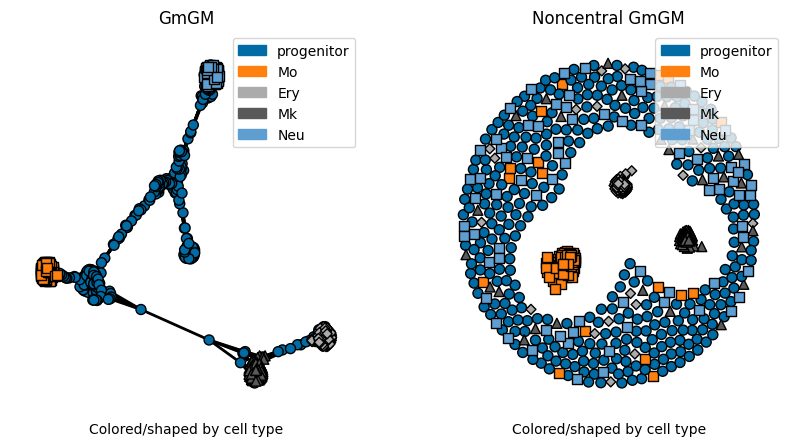

In [42]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "Noncentral GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_nks_gmgm_connectivities',
   fig=fig,
   ax=ax2
)

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities'

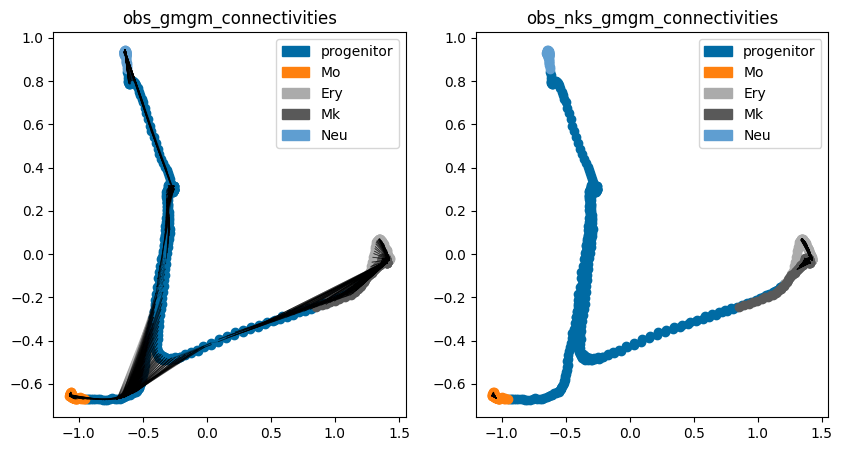

In [43]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_nks_gmgm_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

And now gene graph results.

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Noncentral GmGM'}, xlabel='Colored/shaped by connected components'>)

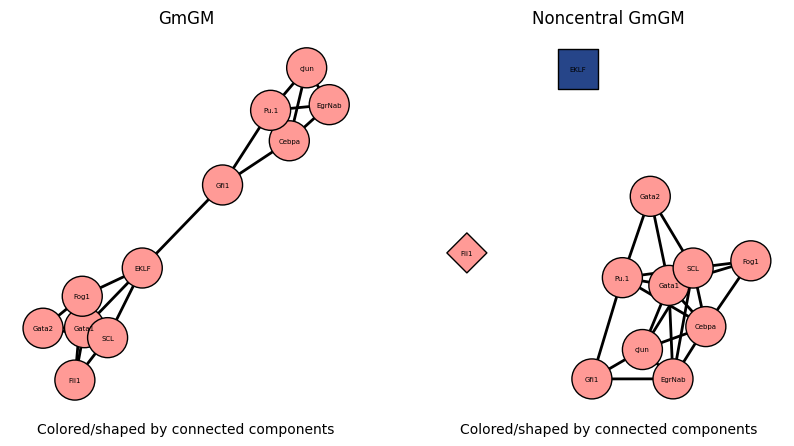

In [44]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
plot_genes(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_genes(
   "Noncentral GmGM",
   krum_data,
   layout='fr',
   graph_type='var_nks_gmgm_connectivities',
   ax=axs[1],
   fig=fig
)

It seems like performance got worse!  There are two explanations:

1) As it is a more complicated model, it overfits
2) Even though non-zero means violate the assumptions of the model, the means are actually informative for the data

Below, we give a PCA plot of the mean expression of each cell - we can see that there is a clear gradient as we move towards different cell types, indicating that the means are informative.  By taking them out using our noncentral method, we loose this information in the graph creation stage - which is ultimately more damaging than the benefit we get from centering the data.

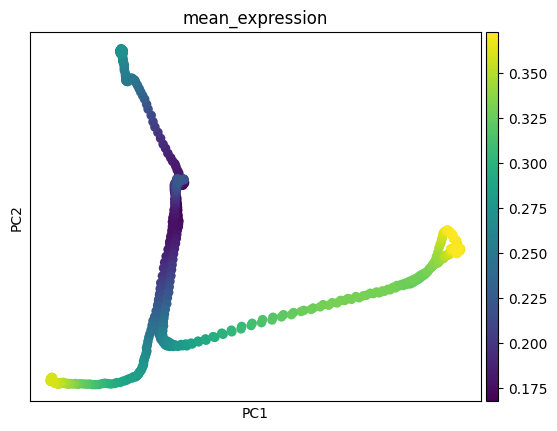

In [45]:
krum_data.obs['mean_expression'] = krum_data.X.mean(axis=1)
sc.pl.pca(krum_data, color='mean_expression')

We can also check that the cell means are really being removed by seeing how well the noncentral model's mean result aligns with the empirical means - as we can see below, all cell means are less than 3% what they once were.  This is what the model is "supposed" to do; but it seems like, in this situation, it's not ideal!

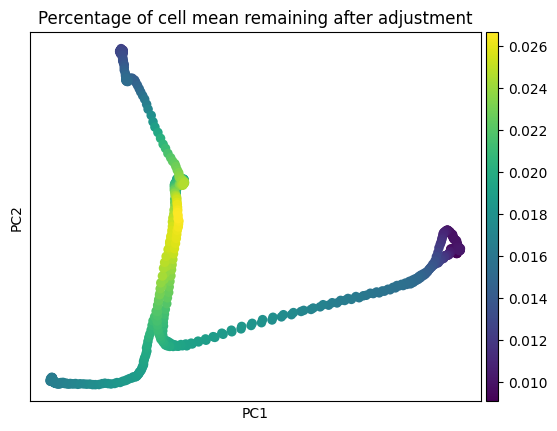

In [46]:
krum_data.obs['adjusted_expression'] = np.abs((
    krum_data.X.mean(axis=1) - means_gmgm_noncentral[0]['cell'] - means_gmgm_noncentral[1]
) / krum_data.X.mean(axis=1))
sc.pl.pca(krum_data, color='adjusted_expression', title="Percentage of cell mean remaining after adjustment")

We could then explore just naively removing the overall mean, if we assume it's the cell-specific means that are worsening the algorithm.

In [47]:
dataset_gmgm_naive_noncentral = GmGM.Dataset(
    dataset={'data': krum_data.X - krum_data.X.mean()},
    structure={'data': (f'cell', f'gene')},
    batch_axes=None
)
results = GmGM.GmGM(
    dataset_gmgm_naive_noncentral,
    to_keep={"cell": 5, "gene": 3},
    min_edges={"cell": 0, "gene": 0},
    threshold_method="rowwise-col-weighted"
)
krum_data.obsp["obs_naive_gmgm_connectivities"] = results.precision_matrices["cell"].toarray()
krum_data.varp["var_naive_gmgm_connectivities"] = results.precision_matrices["gene"].toarray()
krum_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities', 'var_naive_gmgm_connectivities'

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Naively Noncentral GmGM'}, xlabel='Colored/shaped by cell type'>)

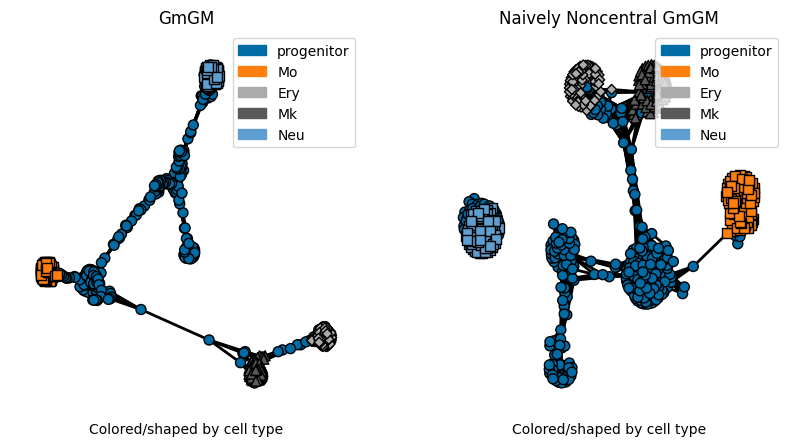

In [48]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "Naively Noncentral GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_naive_gmgm_connectivities',
   fig=fig,
   ax=ax2
)

It seems like global structure has returned to the graph (to an extent, at least!).  So our hypothesis of the cell means being important for recovery in this case is likely correct!  Which is a little frustrating for me, since I want to advertise our new "noncentral" method :P  But the data says what the data says; in this case, it makes things worse.

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities', 'var_naive_gmgm_connectivities'

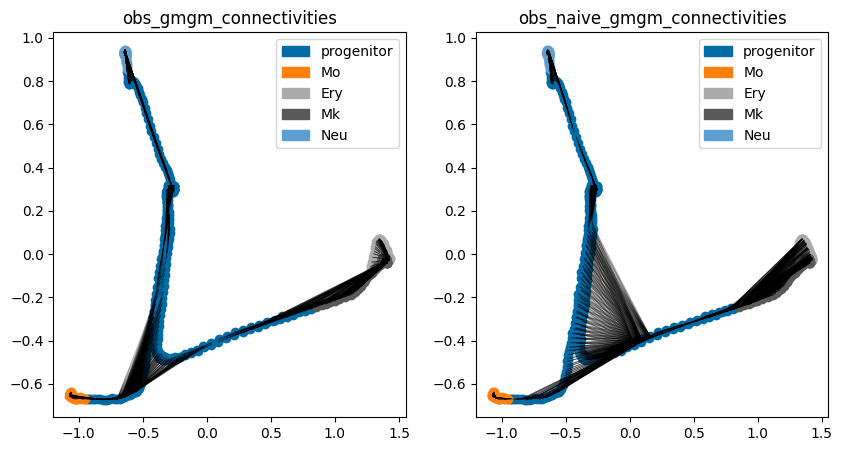

In [49]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_naive_gmgm_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Naively Noncentral GmGM'}, xlabel='Colored/shaped by connected components'>)

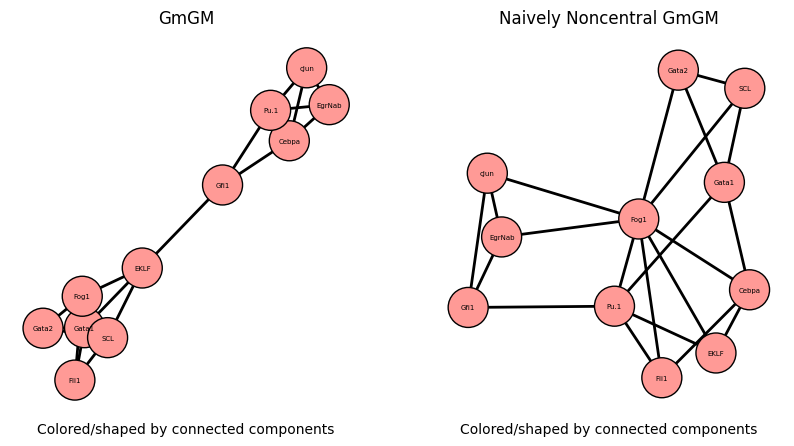

In [50]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
plot_genes(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_genes(
   "Naively Noncentral GmGM",
   krum_data,
   layout='fr',
   graph_type='var_naive_gmgm_connectivities',
   ax=axs[1],
   fig=fig
)

Which do you think is better?  Below, calculate some metrics (like we did earlier) comparing the two models.

In [51]:
# your code here

GmGM (along with GLasso, TeraLasso, the strong product model, etc...) all assume that our data is Gaussian.  Obviously, this is false!  We can relax this assumption by using the "nonparanormal skeptic" (https://icml.cc/2012/papers/707.pdf), which replaces it with the weaker "Gaussian copula" assumption.  Without getting technical, the Gaussian copula assumption is that our data can follow _any_ continuous distribution, but that genes/cells "interact Gaussianly".  It's possible to test if this assumption is satisfied, but we won't get into that in this workshop.

The nonparanormal skeptic is implemented within the GmGM package, we just need to toggle `use_nonparanormal_skeptic=True`.  More broadly, it can be used with any Kronecker-sum-structured method, but not with non-Kronecker-sum methods like the strong product.

In [52]:
krum_data = GmGM.GmGM(
    krum_data,
    to_keep={"obs": 5, "var": 3},
    min_edges={"obs": 0, "var": 0},
    threshold_method="rowwise-col-weighted",
    use_nonparanormal_skeptic=True,
    key_added="nonpara_gmgm"
)
krum_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors', 'obs_neighbors_nonpara_gmgm', 'var_neighbors_nonpara_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities', 'obs_nonpara_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities', 'var_naive_gmgm_connectivities', 'var_nonpara_gmgm_connectivities'

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Copula GmGM'}, xlabel='Colored/shaped by cell type'>)

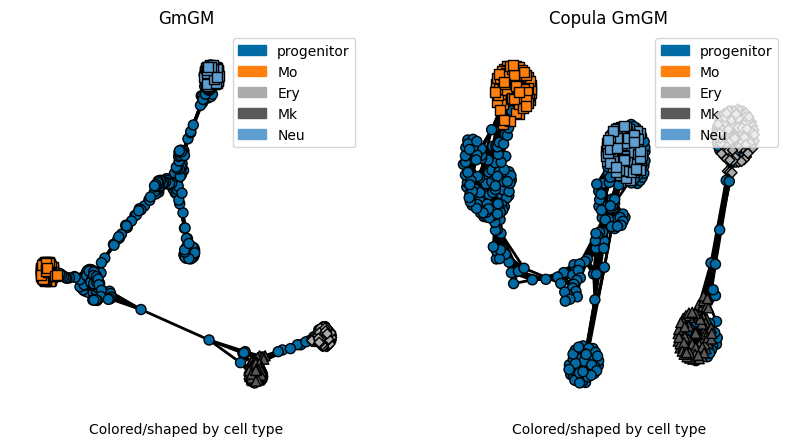

In [53]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "Copula GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_nonpara_gmgm_connectivities',
   fig=fig,
   ax=ax2
)

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors', 'obs_neighbors_nonpara_gmgm', 'var_neighbors_nonpara_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities', 'obs_nonpara_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities', 'var_nks_gmgm_connectivities', 'var_naive_gmgm_connectivities', 'var_nonpara_gmgm_connectivities'

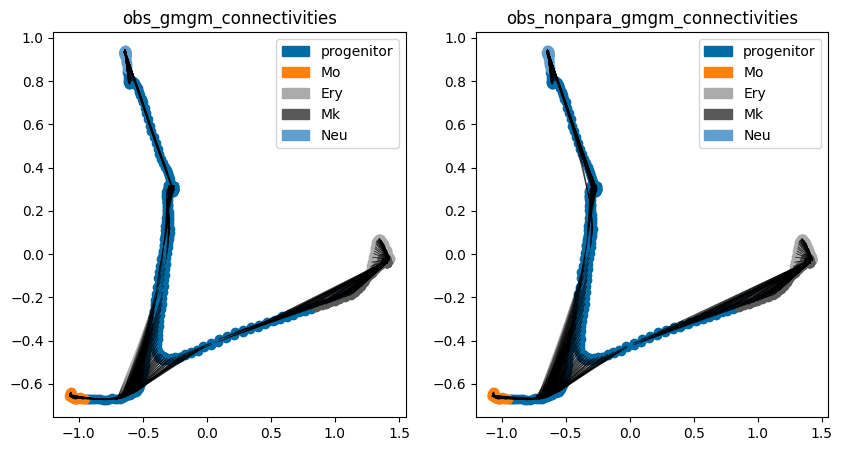

In [54]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_nonpara_gmgm_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Copula GmGM'}, xlabel='Colored/shaped by connected components'>)

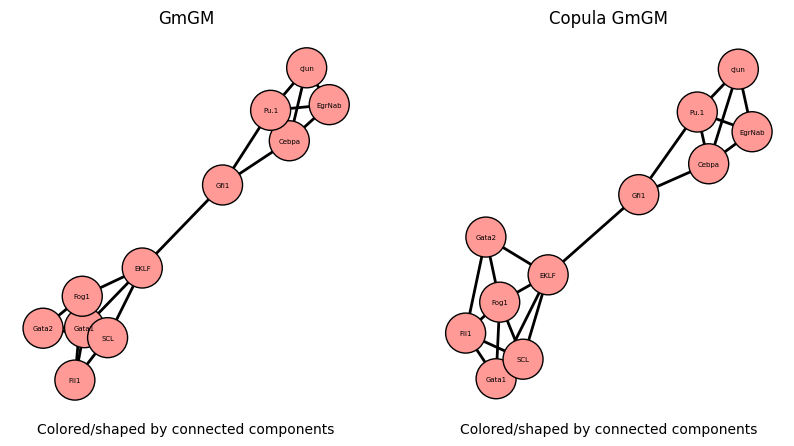

In [55]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
plot_genes(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_genes(
   "Copula GmGM",
   krum_data,
   layout='fr',
   graph_type='var_nonpara_gmgm_connectivities',
   ax=axs[1],
   fig=fig
)

The results are quite similar.  Below, feel free to do a more objective comparison of the results by using the metrics we explored earlier.  Does the benefit we gain from relaxing the Gaussian assumption outweigh the parsimony lost through a more complex model?  In my experience it really depends on a case-by-case basis.

In [56]:
# your code here!

There's one last drawback we'd like to circumvent: scalability!  In practice, GmGM scales up until you have tens of thousands of cells.  However, some modern datasets have millions of cells!

If we make a 'low rank assumption', in particular that the pertinant features of the dataset are visible in only the first couple of principal components, then we can scale much further!  Since our dataset is only 640x11, it's not that useful here...  the maximum number of PCs is `min(#cells, #genes)`, which is 11 here - not much wiggle room to decrease PCs!  Nevertheless we'll give an example of how to run it.

Choosing too few PCs decreases the accuracy (see [our preprint](https://arxiv.org/abs/2407.19892) to get a feel for how much accuracy drops off), so it's a trade-off.  My rule-of-thumb is to start decreasing PCs once `max(genes, cells) > ~2000` for quick tests, with it becoming practically mandatory once `max(genes, cells) > ~20000`

In [57]:
# Standard GmGM
krum_data = GmGM.GmGM(
    krum_data,
    to_keep={"obs": 5, "var": 3},
    min_edges={"obs": 0, "var": 0},
    threshold_method="rowwise-col-weighted",
    use_nonparanormal_skeptic=False, 
    n_comps=7,
    key_added="7pc_gmgm"
)

# Nonparametric GmGM
krum_data = GmGM.GmGM(
    krum_data,
    to_keep={"obs": 5, "var": 3},
    min_edges={"obs": 0, "var": 0},
    threshold_method="rowwise-col-weighted",
    use_nonparanormal_skeptic=True, 
    n_comps=7,
    key_added="7pc_nonpara_gmgm"
)
krum_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/core/core.py:63: UserWarning: `nonparanormal_evec_backend` unspecified, defaulting to `COCA`
  warnings.warn("`nonparanormal_evec_backend` unspecified, defaulting to `COCA`")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors', 'obs_neighbors_nonpara_gmgm', 'var_neighbors_nonpara_gmgm', 'obs_neighbors_7pc_gmgm', 'var_neighbors_7pc_gmgm', 'obs_neighbors_7pc_nonpara_gmgm', 'var_neighbors_7pc_nonpara_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities', 'obs_nonpara_gmgm_connectivities', 'obs_7pc_gmgm_connectivities', 'obs_7pc_nonpara_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities

(<Figure size 1500x500 with 3 Axes>,
 <Axes: title={'center': 'Copula GmGM (7 PCs)'}, xlabel='Colored/shaped by cell type'>)

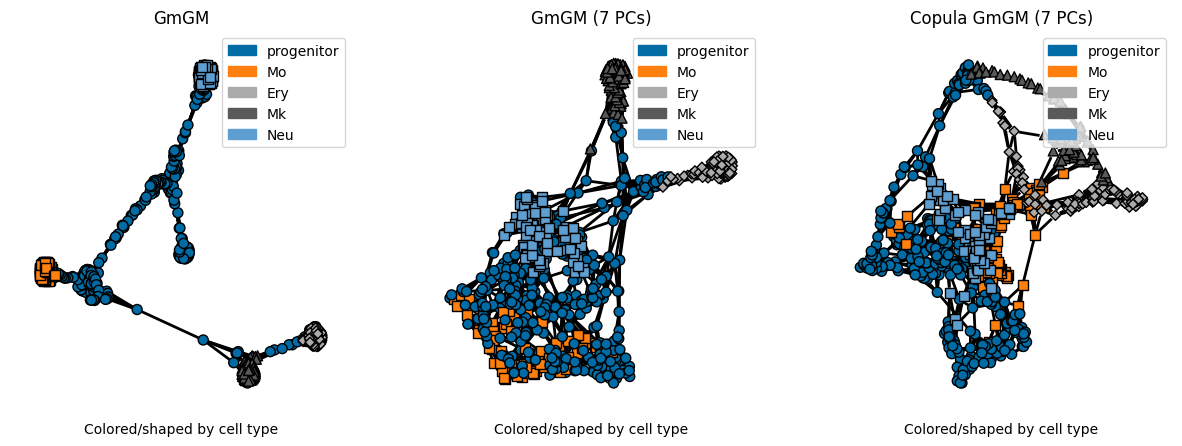

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)

plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "GmGM (7 PCs)",
   krum_data,
   layout='fr',
   graph_type='obs_7pc_gmgm_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Copula GmGM (7 PCs)",
   krum_data,
   layout='fr',
   graph_type='obs_7pc_nonpara_gmgm_connectivities',
   fig=fig,
   ax=ax3
)

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso', 'mean_expression', 'adjusted_expression'
    var: 'Mo_genes', 'Ery_genes', 'Mk_genes', 'Neu_genes'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso', 'neighbors', 'obs_neighbors_nonpara_gmgm', 'var_neighbors_nonpara_gmgm', 'obs_neighbors_7pc_gmgm', 'var_neighbors_7pc_gmgm', 'obs_neighbors_7pc_nonpara_gmgm', 'var_neighbors_7pc_nonpara_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_sp_connectivities', 'distances', 'connectivities', 'obs_nks_gmgm_connectivities', 'obs_naive_gmgm_connectivities', 'obs_nonpara_gmgm_connectivities', 'obs_7pc_gmgm_connectivities', 'obs_7pc_nonpara_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities

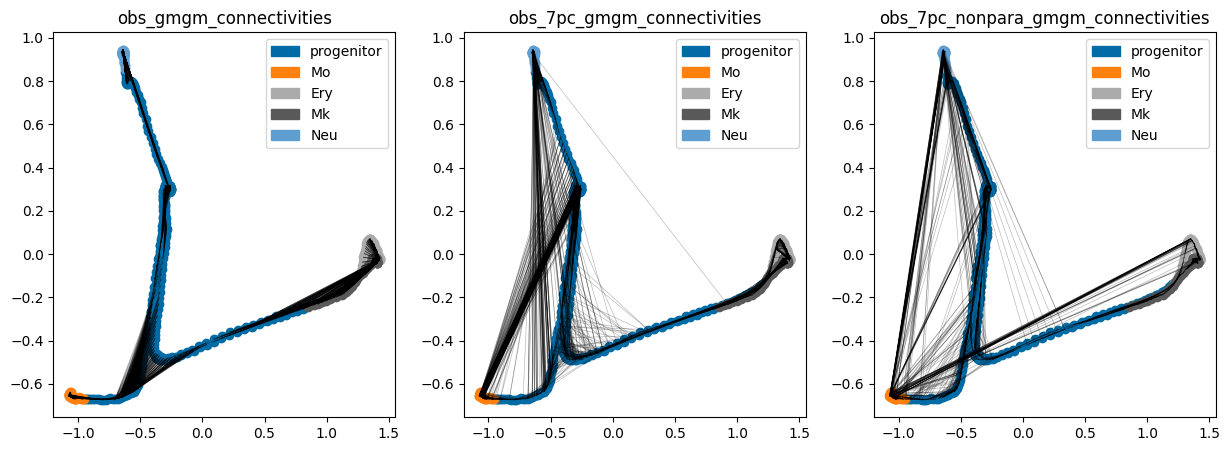

In [59]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_7pc_gmgm_connectivities", "obs_7pc_nonpara_gmgm_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

(<Figure size 1500x500 with 3 Axes>,
 <Axes: title={'center': 'Copula GmGM (7 PCs)'}, xlabel='Colored/shaped by connected components'>)

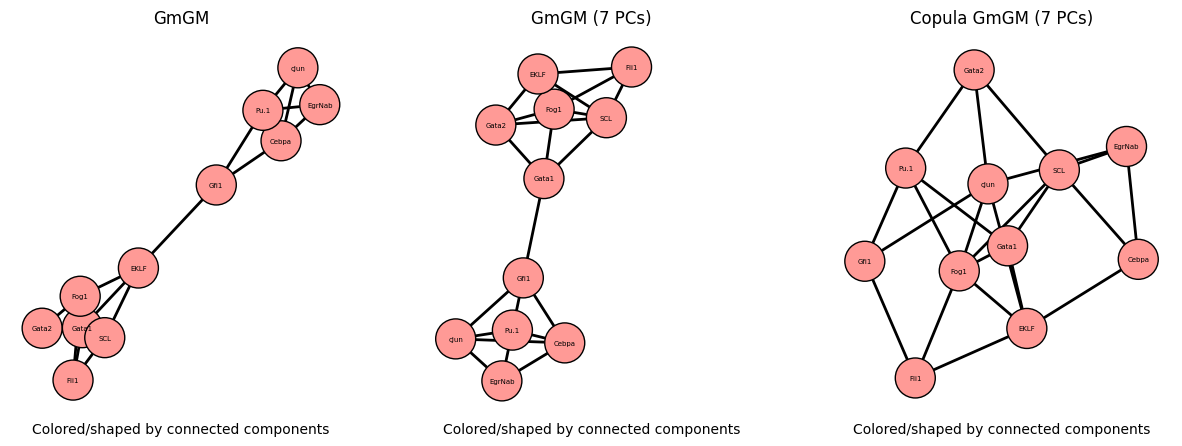

In [60]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
plot_genes(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_genes(
   "GmGM (7 PCs)",
   krum_data,
   layout='fr',
   graph_type='var_7pc_gmgm_connectivities',
   ax=axs[1],
   fig=fig
)
plot_genes(
   "Copula GmGM (7 PCs)",
   krum_data,
   layout='fr',
   graph_type='var_7pc_nonpara_gmgm_connectivities',
   ax=axs[2],
   fig=fig
)

As always, how do you think these methods compare?  Below, run some empirical tests to determine your opinions objectively!

It'd definitely be worth playing with other amounts of principal components, such as 10, since the amount you have to work with (11) is so small!  The drop off in performance here will likely be more dramatic than normal.

In [61]:
# put your code here

### How to choose the number of principal components?

Actually, these can be chosen the same way you 'normally' would.  Often, people do this by trying to achieve a certain percentage of explained variance (although there are other methods).  Below, we can see that the first three components already account for 90% of the variance in this dataset.

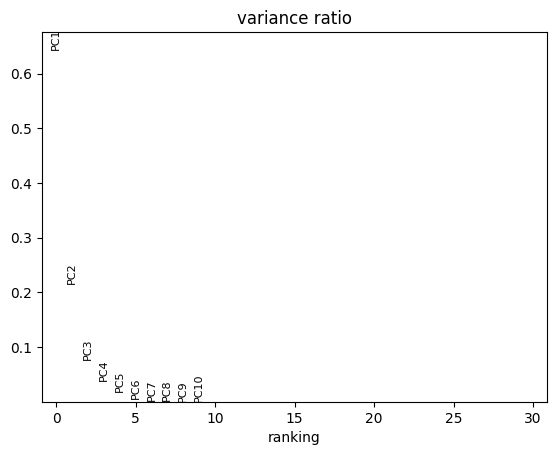

In [62]:
sc.pl.pca_variance_ratio(krum_data)

# Part 3: Shared Axes

This is the final section of this workshop.  We'll see how to apply GmGM to multi-modal datasets, which is as of now an ability unique to it among the Kronecker-structured models.

The idea rests on the concept of "shared axes".  Let's consider three different datasets:

1) A (cell, gene) scRNA-seq data matrix coupled with a (cell, peak) scATAC-seq data matrix on the same cells
2) Two (cell, gene) scRNA-seq data matrices from different patients with the same underlying condition
3) A (patient, metabolite) metabolomics data matrix with a (patient, gene) bulk RNA-seq data matrix from the same patients

In each of these datasets, there is a "shared axis" - `cell` is shared between the scRNA-seq and scATAC-seq matrices in [1], `gene` is shared between the patients in [2], and `patient` is shared in [3].  The shared axis gains information from both matrices in the dataset, and thus our estimates can be enhanced by considering the dataset holistically.

This concept extends to very general settings - any time we have a set of tensors with shared axes, this approach could be used.  Let `(...)` define a tensor with the given axes, for example `(cell, gene)` defines a matrix whose rows are cells and columns are genes.  Then we could even analyze the following hypothetical dataset (representing the effect of eating different meals on your omics...) using the "shared axis approach":

`(meal, patient, metabolites) + (patient, genes) + sum_i (cells of patient i, genes)`

In [63]:
# Get the data we pre-downloaded
sc._settings.ScanpyConfig.datasetdir = Path('../data/')
adata = sc.datasets.ebi_expression_atlas(
    accession='E-GEOD-130148',
)
sc.pp.log1p(adata)

# Keep only highly variable genes
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]

adata.obs['cell_type'] = adata.obs['Factor Value[inferred cell type - ontology labels]']

sc.pp.pca(adata)
adata

/tmp/ipykernel_30120/1333396701.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = adata.obs['Factor Value[inferred cell type - ontology labels]']


AnnData object with n_obs × n_vars = 3566 × 2456
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[disease staging]', 'Sample Characteristic Ontology Term[disease staging]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Factor Value[sampling site]', 'Factor Value Ontology Term[sampling site]', 'Factor Value[disease]', 'Factor Value Ontology Term[disease]', 'Facto

The gene names are stored as ENSG codes, so let's get the (human-readable) external gene names as well.

In [64]:
mapping = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "external_gene_name"]
)
mapping = mapping.set_index("ensembl_gene_id")
mapping = mapping[mapping.index.isin(adata.var_names)]

# Add to adata
adata.var["external_gene_name"] = "Not in Biomart"
adata.var.loc[adata.var_names.isin(mapping.index), "external_gene_name"] = mapping["external_gene_name"]
adata.var.loc[adata.var["external_gene_name"].isna(), "external_gene_name"] = "Biomart NaN"
adata.var["external_gene_name"]

ENSG00000000003         TSPAN6
ENSG00000000419           DPM1
ENSG00000000971            CFH
ENSG00000001084           GCLC
ENSG00000001460          STPG1
                      ...     
ENSG00000288297          ECSCR
ENSG00000288299           LDHA
ENSG00000288411           SAA1
ENSG00000288512            C1R
ENSG00000289697    Biomart NaN
Name: external_gene_name, Length: 2456, dtype: object

We can see below that there are four individuals in the dataset.  Clearly the cells of one individual will have **no relation** to the cells of another.  It we treated this as a single `(cell, gene)` matrix, the cell graph could potentially learn edges between cells of different individuals, which is not what we want.  Rather, we should split it into four `(cell, gene)` matrices, where each patient gets their own matrix - the `gene` axis will be used to share information across patients, and only one gene network will be learned.

(This is of course application-dependent; if our only goal is to cluster cell types together, then we would actually want to learn edges across individuals).

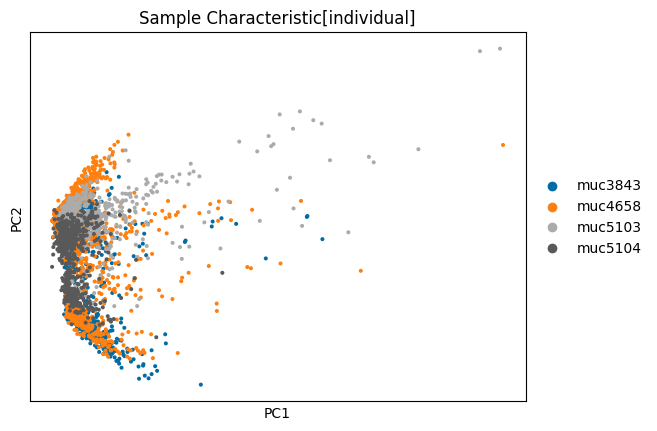

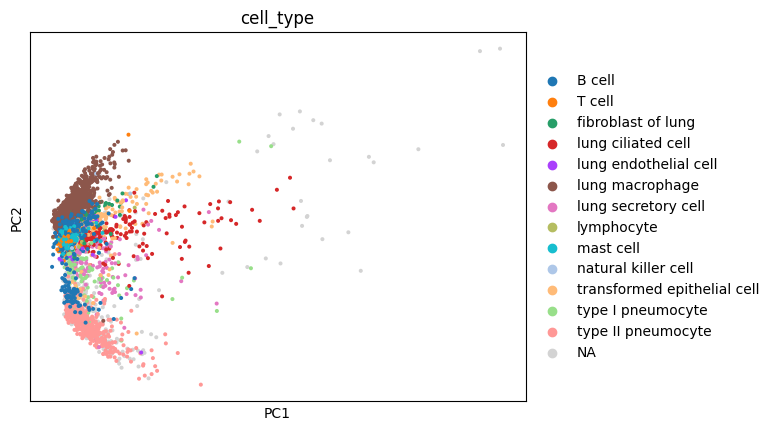

In [65]:
sc.pl.pca(adata, color='Sample Characteristic[individual]')
sc.pl.pca(adata, color='cell_type')

In [66]:
patient_1 = adata[adata.obs['Sample Characteristic[individual]'] == 'muc3843']
patient_2 = adata[adata.obs['Sample Characteristic[individual]'] == 'muc4658']
patient_3 = adata[adata.obs['Sample Characteristic[individual]'] == 'muc5103']
patient_4 = adata[adata.obs['Sample Characteristic[individual]'] == 'muc5104']
patient_1

View of AnnData object with n_obs × n_vars = 872 × 2456
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[disease staging]', 'Sample Characteristic Ontology Term[disease staging]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Factor Value[sampling site]', 'Factor Value Ontology Term[sampling site]', 'Factor Value[disease]', 'Factor Value Ontology Term[disease]',

In [67]:
dataset_gmgm_noncentral = GmGM.Dataset(
    dataset={'patient 1': patient_1.X, 'patient 2': patient_2.X, 'patient 3': patient_3.X, 'patient 4': patient_4.X},
    structure={
        'patient 1': ('cell 1', 'gene'),
        'patient 2': ('cell 2', 'gene'),
        'patient 3': ('cell 3', 'gene'),
        'patient 4': ('cell 4', 'gene')
    },
    batch_axes=None
)

results = GmGM.GmGM(
    dataset_gmgm_noncentral,
    to_keep={"cell 1": 5, "cell 2": 5, "cell 3": 5, "cell 4": 5, "gene": 3},
    threshold_method="rowwise-col-weighted"
)

patient_1.obsp['patient_1_connectivities'] = results.precision_matrices['cell 1']
patient_2.obsp['patient_2_connectivities'] = results.precision_matrices['cell 2']
patient_3.obsp['patient_3_connectivities'] = results.precision_matrices['cell 3']
patient_4.obsp['patient_4_connectivities'] = results.precision_matrices['cell 4']
for object in [patient_1, patient_2, patient_3, patient_4]:
    object.varp['gene_connectivities'] = results.precision_matrices['gene']

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set patient 1's tensor of type <class 'anndata._core.views.SparseCSRMatrixView'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set patient 2's tensor of type <class 'anndata._core.views.SparseCSRMatrixView'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set patient 3's tensor of type <class 'anndata._core.views.SparseCSRMatrixView'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set patient 4's tensor of type <class 'anndata._core.views.SparseCSRMat

(<Figure size 2000x2000 with 4 Axes>,
 <Axes: title={'center': 'Patient 4'}, xlabel='Colored/shaped by cell type'>)

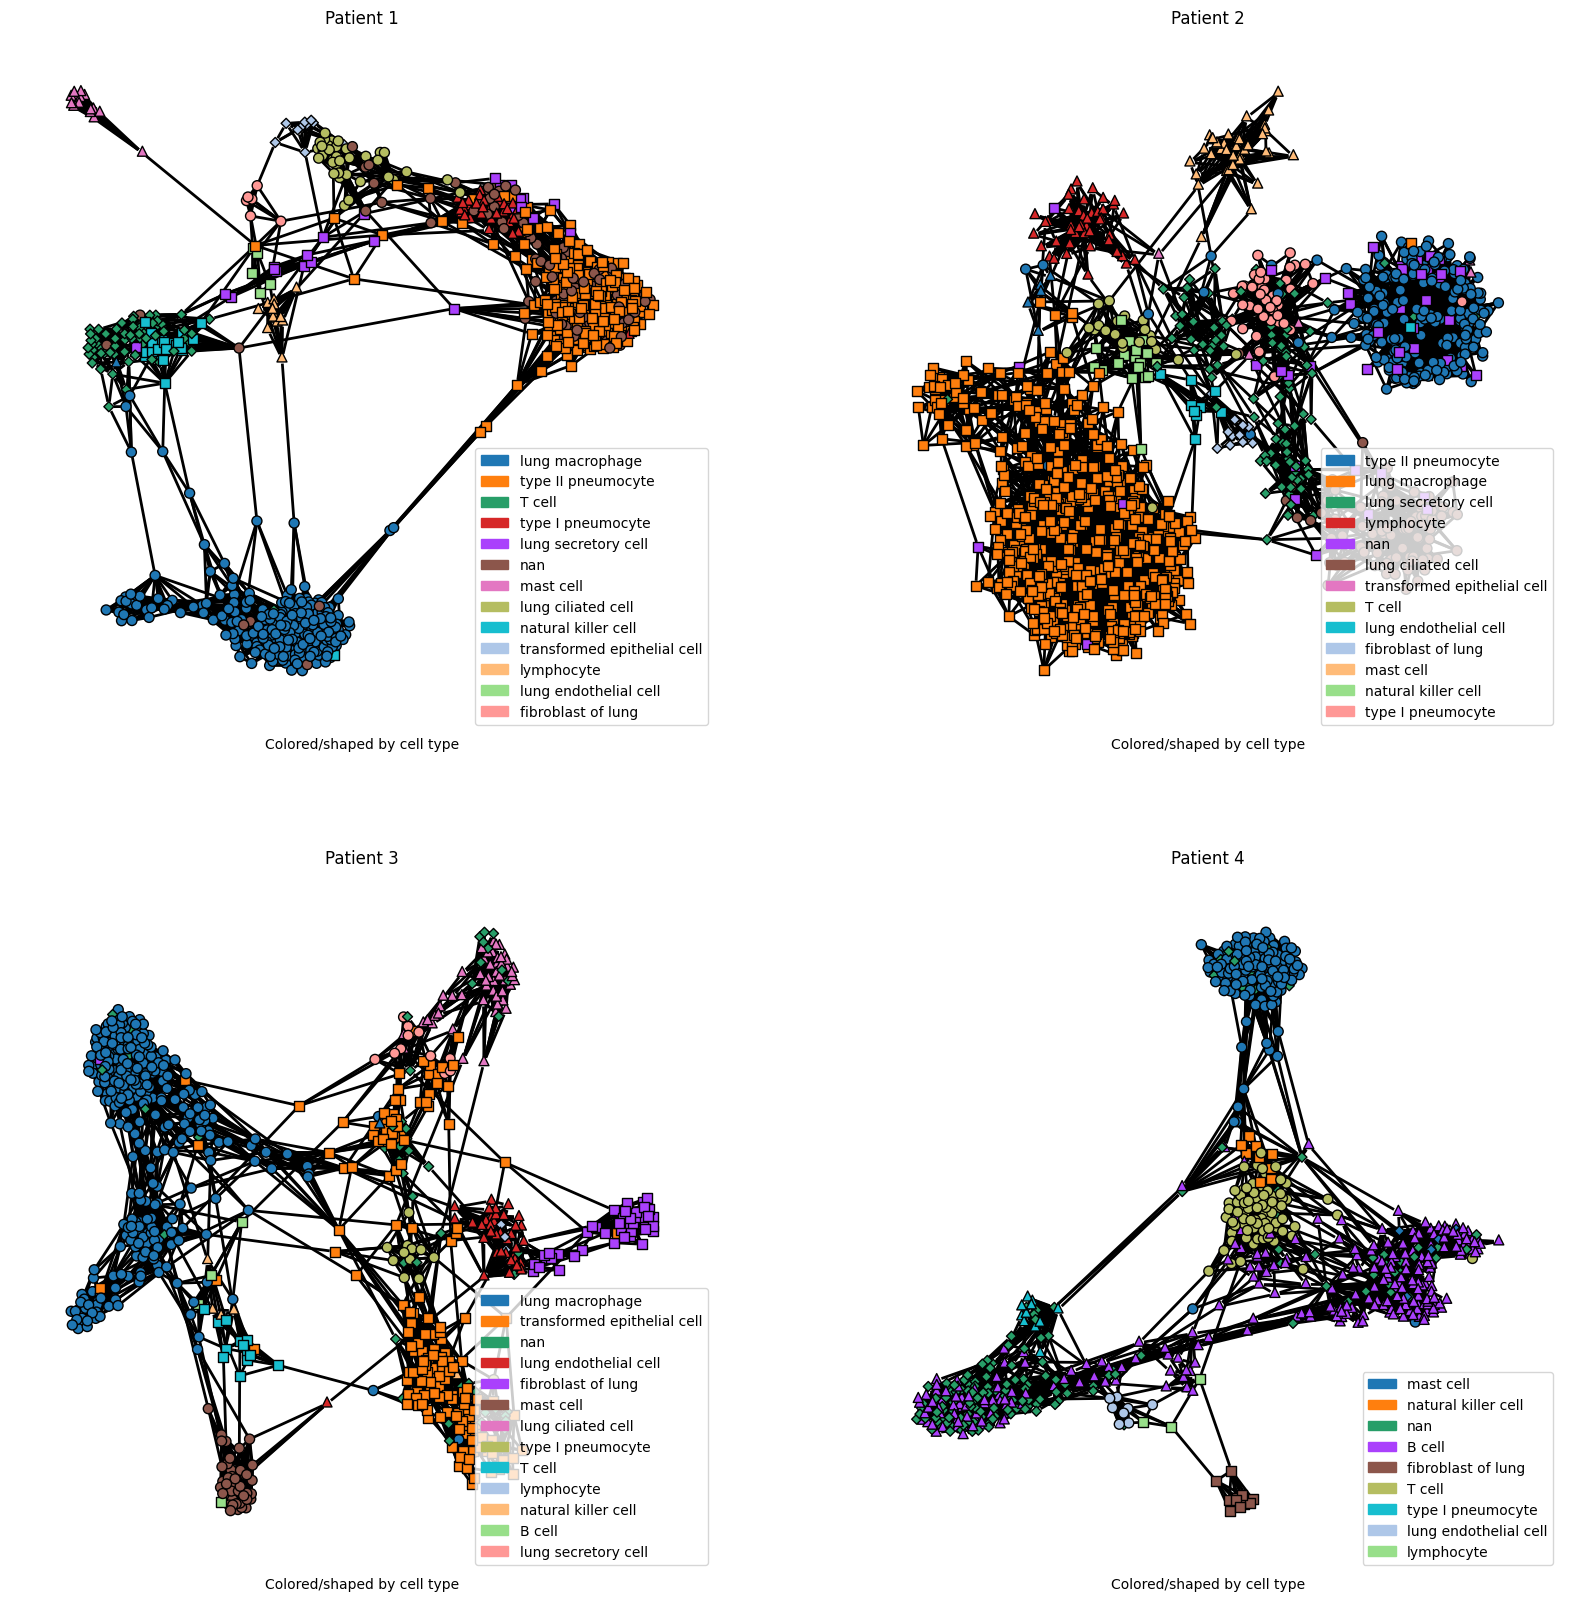

In [68]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
axs = axs.flatten()

plot_cells(
   "Patient 1",
   patient_1,
   layout='fr',
   graph_type='patient_1_connectivities',
   fig=fig,
   ax=axs[0],
   legend_loc='lower right'
)
plot_cells(
   "Patient 2",
   patient_2,
   layout='fr',
   graph_type='patient_2_connectivities',
   fig=fig,
   ax=axs[1],
   legend_loc='lower right'
)
plot_cells(
   "Patient 3",
   patient_3,
   layout='fr',
   graph_type='patient_3_connectivities',
   fig=fig,
   ax=axs[2],
   legend_loc='lower right'
)
plot_cells(
   "Patient 4",
   patient_4,
   layout='fr',
   graph_type='patient_4_connectivities',
   fig=fig,
   ax=axs[3],
   legend_loc='lower right'
)

Based on a visual inspection, it seems to be doing a pretty good job separating the cell types!  Use some metric to get an objective measure of its performance here.

In [69]:
# your code here

There are too many genes now to display the full gene graph in a meaningful manner.  To understand our performance, we can do two tests:

1) Pick a group of genes we know should be connected, and check if they are connected
2) Look at clusters of genes that we connect, and see if they correspond to groups with some functional purpose in common

Here, we'll look at genes involved in immunoglobulin receptor binding (i.e. test [1]).  I've done a fairly naive way to subset these genes, by just looking for genes that start with "IG".  Man genes, such as IGHA1 and IGLC3, are relevant here, but this method will also grab irrelevant genes - for example, genes starting with "IGF" are typically to do with insulin-like growth factors instead.

This isn't the best way to verify the gene graph, as not every cluster we expect to exist will necessarily exist - for example, ribosomal genes connect  in this dataset (replace "IG" with "RPS" or "RPL" for an ad-hoc verification of this).  There's only so many edges to go around, based on the sparsity we chose when running the algorithm, so the clusters more relevant for explaining the variability in the dataset will take precedence.  Feel free to look at other gene groups; but unless you have domain knowledge as to what genes you think dominate in this dataset, it's likely not worthwhile.

/workspaces/ellis-summerschool/notebooks/utilities.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = var_names


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Immunoglobulin Genes (GmGM)'}, xlabel='Colored/shaped by connected components'>)

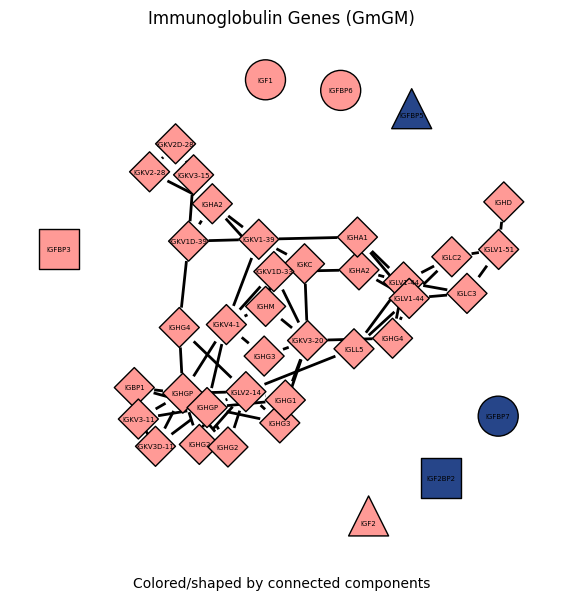

In [70]:
# Doesn't matter which patient we choose as they all have same gene matrix
igg = patient_1[:, patient_1.var["external_gene_name"].str.startswith("IG")]

plot_genes(
   "Immunoglobulin Genes (GmGM)",
   igg,
   layout='fr',
   graph_type='gene_connectivities',
   var_names=igg.var["external_gene_name"]
)

The second way to validate performance is to cluster on the graph, and check if those clusters correspond to relevant biological functions.  Let's cluster.

In [71]:
bdata = patient_1.T
display(bdata)
sc.tl.leiden(bdata, obsp="gene_connectivities", key_added='leiden_gmgm')

AnnData object with n_obs × n_vars = 2456 × 872
    obs: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'external_gene_name'
    var: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[disease staging]', 'Sample Characteristic Ontology Term[disease staging]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Factor Value[sampling site]', 'Factor Value Ontology 

We'll now consult the internet (in particular, the [gprofiler database](https://biit.cs.ut.ee/gprofiler/gost)) to pull down relevant annotations for our clusters.  This requires internet connection and may take ~30 seconds.

In [72]:
# This cell will download a list of GO terms associated with each cluster.
def create_pathway_df(
    adata: ad.AnnData,
    graph_type: str,
) -> pd.DataFrame:

    leiden_string = f"leiden_{graph_type}"

    gp = GProfiler(return_dataframe=True)
    pathway_df = gp.profile(
        organism="hsapiens",
        query={
            f"Cluster {module}": adata[adata.obs[leiden_string] == module].obs_names.values.tolist()
            for module in adata.obs[leiden_string].unique()
        }
    )

    pathway_df.to_csv(f"../results/pathways_{graph_type}.csv")

    return pathway_df

pathway_df_gmgm = create_pathway_df(bdata, "gmgm")



Below are the outputs.  For those unfamiliar, "GO terms" are formalized annotations for the functionality (and some other characteristics) of genes.  The most relevant columns are "name" for the name of the GO term, "p_value", and "query" for the cluster it relates to.

In [73]:
pathway_df_gmgm

source      native                                     name  \
0     GO:CC  GO:0005929                                   cilium   
1     GO:BP  GO:0044782                      cilium organization   
2     GO:CC  GO:0005930                                  axoneme   
3     GO:CC  GO:0097014                            ciliary plasm   
4     GO:BP  GO:0060271                          cilium assembly   
...     ...         ...                                      ...   
2300  CORUM  CORUM:6598                    CC2D2A-CEP290 complex   
2301  CORUM  CORUM:6594                    CCP110-CEP290 complex   
2302  GO:CC  GO:0071745               IgA immunoglobulin complex   
2303  GO:BP  GO:0001738  morphogenesis of a polarized epithelium   
2304   KEGG  KEGG:05163          Human cytomegalovirus infection   

            p_value  significant  \
0     5.147428e-166         True   
1     2.698719e-117         True   
2     3.009978e-116         True   
3     6.158821e-116         True   
4     4.221213e-113         True   
...             ...          ...   
2300   4.972907e-02         True   
2301   4.972907e-02         True   
2302   4.986900e-02         True   
2303   4.993506e-02         True   
2304   4.998276e-02         True   

                                            description  term_size  \
0     "A specialized eukaryotic organelle that consi...        769   
1     "A process that is carried out at the cellular...        418   
2     "The bundle of microtubules and associated pro...        175   
3     "All of the contents of a cilium, excluding th...        176   
4     "The assembly of a cilium, a specialized eukar...        391   
...                                                 ...        ...   
2300                              CC2D2A-CEP290 complex          2   
2301                              CCP110-CEP290 complex          2   
2302  "A protein complex composed of two identical i...          6   
2303  "The morphogenetic process in which the anatom...         57   
2304                    Human cytomegalovirus infection        223   

      query_size  intersection_size  effective_domain_size  precision  \
0            353                179                  22115   0.507082   
1            319                118                  21017   0.369906   
2            353                 91                  22115   0.257790   
3            353                 91                  22115   0.257790   
4            319                113                  21017   0.354232   
...          ...                ...                    ...        ...   
2300          45                  2                   3383   0.044444   
2301          45                  2                   3383   0.044444   
2302         438                  3                  22115   0.006849   
2303         319                  7                  21017   0.021944   
2304         109                 10                   8484   0.091743   

        recall      query                               parents  
0     0.232770  Cluster 1              [GO:0043227, GO:0120025]  
1     0.282297  Cluster 1              [GO:0006996, GO:0120036]  
2     0.520000  Cluster 1  [GO:0005856, GO:0097014, GO:0110165]  
3     0.517045  Cluster 1              [GO:0005929, GO:0032838]  
4     0.289003  Cluster 1  [GO:0044782, GO:0070925, GO:0120031]  
...        ...        ...                                   ...  
2300  1.000000  Cluster 1                       [CORUM:0000000]  
2301  1.000000  Cluster 1                       [CORUM:0000000]  
2302  0.500000  Cluster 0                          [GO:0019814]  
2303  0.122807  Cluster 1                          [GO:0002009]  
2304  0.044843  Cluster 2                          [KEGG:00000]  

[2305 rows x 14 columns]

The code below will look through all all clusters and calculate over-representation of GO terms in a cluster.  In short, if the p-value is low then the GO term is unlikely to be so prevalent in a cluster by chance - this is a good thing!

Since there are several clusters, rather than displaying all results in this notebook, we save them to `results`; have a peek in the directory, in particular the `top_pathways` and `graph` files in each cluster.

Creating results...


NameError: name 'os' is not defined

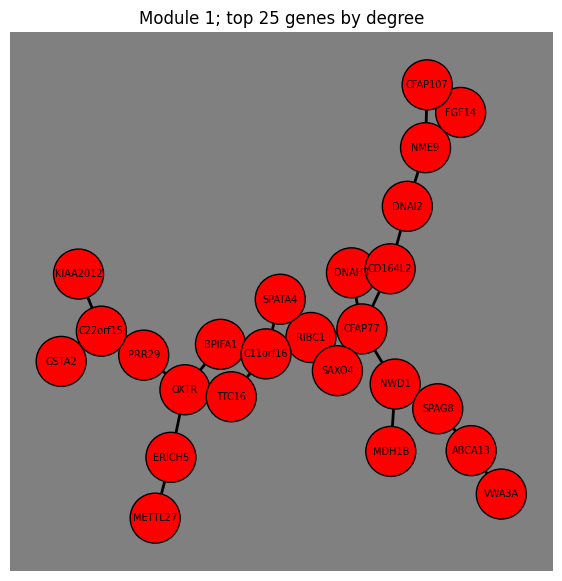

In [74]:
print("Creating results...")

# Overwrite old results, if they exist
if os.path.exists(f"../results/gmgm"):
    shutil.rmtree(f"../results/gmgm")

if os.path.exists(f"../results/glasso"):
    shutil.rmtree(f"../results/glasso")

# Generate new results
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for module in bdata.obs["leiden_gmgm"].unique():
        if module == "Singleton":
            continue

        (fig, _), _ = plot_graph(
            bdata,
            module,
            key="gene",
            pathway_df=pathway_df_gmgm,
            graph_type="gmgm",
            save=True,
            vertex_names="external_gene_name",
            top_genes=25,
            top_pathways=10,
            display_centrality="degree",
        )

        # Close figures to prevent notebook slowing down.
        plt.close(fig)

print("Done!")


This is the end of the guided portion of the notebook.  Hopefully you've been able to experiment with GmGM, it's various settings, and other algorithms that attempt similar things.  Below, we encourage you to play around with these datasets, or others ([scanpy has some built-in unimodal datasets](https://scanpy.readthedocs.io/en/stable/api/datasets.html), for example).  Here's a list of some interesting experiments to run, but feel free to plan and execute your own!:

1) Re-run this code without splitting the dataset into each patient - how do the results change?

2) Suppose you have a dataset with multiple cell types.  Pick one cell type, and run GmGM on just that cell type.  Take a look at the gene graph.  Now, pick another cell type and do the same.  Are the gene graphs similar?

3) Compare how using the nonparanormal skeptic/changing the number of PCs for GmGM affects the cell clustering abilities for the datasets considered here.  Note that the `NoncentralKS` method sadly doesn't work when there are multiple axes.

4) Find (online) a scRNA-seq+scATAC-seq dataset, and run GmGM with the cells as a "shared axis".  Compare this to running GmGM on each modality separately.  For example, [you can try this one](https://www.10xgenomics.com/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0)

In [ ]:
# your code here